# Credit Risk Model

In [1]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, classification_report
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from scipy import stats

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 1. Business Understanding

The client (lending company) have loan data and require a credit risk model. Also visualize the result in clear, easy-to-read, and communicative manner.

Credit risk is associated with the possibility of a client failing to meet contractual obligations, such as mortgages, credit card debts, and other types of loans. So, minimizing the risk of default is a major concern for financial institutions. For this reason, lending companies are increasingly relying on technology to predict which clients are more prone to stop honoring their debts.

There are two key components of credit risk: 
1. Probability of default (PD), usually defined as likelihood of default over a period of time
2. Loss given default (LGD), typically referred to as the amount that can not be recovered after the borrower defaults. 

The multiplication of the two components is the expected loss.

There are a number of different strategies that banks and financial institutions use for managing credit risk:
1. Credit limit management, to keep track of how much money they have lent out and how much it is at risk of being defaulted on.
2. Credit scoring, to assign a score to a borrower which represents their creditworthiness.
3. Credit monitoring, to track borrower’s credit behavior over time.

One way of doing those strategies are by using machine learning to better predict credit risk because it can automatically identify patterns in data that humans would not be able to see.

## 2. Analytic Approach

Credit risk modeling is a process of estimating the probability that a borrower will default on their loan. 

The following are some of the credit risk modeling use cases which can be dealt with machine learning:
1. Classification models for who to lend money to (good vs bad customer).
2. Regression models for how much money to lend to a particular customer.
3. Classification model to determine when to pull back by tracking their credit behavior over time to identify changes in credit risk profile.


## 3. Data Requirements

For this credit risk model, we are only using a model to classify whether a new customer is a good or bad borrower. 

Therefore, at minimum, the data should include any relevant information about the good and bad borrowers.

## 4. Data Collection

The relevant structured data is already supplied by other departments in the form of flat file (csv). 

## 5. Data Understanding

Many of the loan level characteristics are the main drivers for credit loss forecasting (e.g. low credit score or low income group are generally more vulnerable to economic conditions and thus lead to default).

In [3]:
df = pd.read_csv('loan_data_2007_2014.csv', index_col=[0])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.shape

(466285, 74)

<b>Note:</b> The loan data contains of 466.285 rows and 74 columns.

In [5]:
df['id'].duplicated().any()

False

<b>Note:</b> The loan data have no duplicate.

In [6]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Note:</b> The loan data contains some null values.

## 6. Data Preparation

### 6.1. Data Processing & Wrangling

Based on description of columns in LCDataDictionary.xlsx, our target variable appears to be loan_status.

### 6.1.1. Predictor Variables

In [7]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()
numerical_columns = df.select_dtypes(include='number').columns.tolist()
print("There are " + str(len(categorical_columns)) + " categorical columns in the data: \n", categorical_columns, "\n")
print("There are " + str(len(numerical_columns)) + " numerical columns in the data: \n", numerical_columns)

There are 22 categorical columns in the data: 
 ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type'] 

There are 52 numerical columns in the data: 
 ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc

### Categorical Variables

In [8]:
df[categorical_columns].describe(include='object').transpose()

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
sub_grade,466285,35,B3,31686
emp_title,438697,205475,Teacher,5399
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
issue_d,466285,91,Oct-14,38782
loan_status,466285,9,Current,224226
pymnt_plan,466285,2,n,466276


<b>Problem</b>: The loan data contains improper values (e.g.: term contains string "months", instead of just number of months).

<b>Solution</b>: Clean the columns and convert them into proper values. 

#### TERM

In [9]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [10]:
df['term'] = pd.to_numeric(df['term'].str.replace(' months', ''))

#### EMP_LENGTH

In [11]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [12]:
# Convert data into the proper numerical values
df['emp_length'] = df['emp_length'].str.replace('\+ years', '')
df['emp_length'] = df['emp_length'].str.replace('< 1 year', str(0))
df['emp_length'] = df['emp_length'].str.replace(' years', '')
df['emp_length'] = df['emp_length'].str.replace(' year', '')
df['emp_length'] = pd.to_numeric(df['emp_length'])

# Replace null with zero values
df['emp_length'].fillna(value=0, inplace=True)

C:\Users\Reza Aldama\AppData\Local\Temp\ipykernel_3672\2264175070.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['emp_length'] = df['emp_length'].str.replace('\+ years', '')


#### EARLIEST_CR_LINE | ISSUE_D | LAST_PYMNT_D | LAST_CREDIT_PULL_D

In [13]:
def convert_date_columns(df, column):
    # Store current day
    today_date = pd.to_datetime('today')
    
    # Convert column to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    
    # Calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    
    # Drop the original date column
    df.drop(columns=[column], inplace=True)

convert_date_columns(df, 'earliest_cr_line')
convert_date_columns(df, 'issue_d')
convert_date_columns(df, 'last_pymnt_d')
convert_date_columns(df, 'last_credit_pull_d')

### Numerical Variables

In [14]:
df[numerical_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01
delinq_2yrs,466256.0,2.846784e-01,7.973651e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+01


<b>Note:</b> The numerical columns contains some null values.

### 6.1.2. Target Variable

In [15]:
# Show relative count for all possible values of loan_status
df['loan_status'].value_counts(normalize=True)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

Based on domain knowledge, we will classify loans with the following loan_status values as bad loan (or 0):
1. Charged Off
2. Default
3. Late (31–120 days)
4. Does not meet the credit policy. Status:Charged Off

While all the other values will be classified as good loan (or 1).

In [16]:
# Convert target variable values into 0 and 1
df['target'] = np.where(df.loc[:,'loan_status'].isin(['Charged Off', 'Default',
                                                      'Late (31-120 days)',
                                                      'Does not meet the credit policy. Status:Charged Off']), 0, 1)
# Drop the original 'loan_status' column
df.drop(columns=['loan_status'], inplace=True)

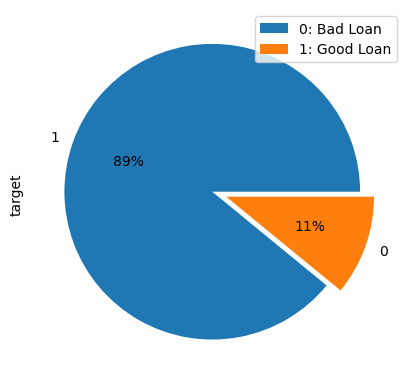

In [17]:
df['target'].value_counts().plot(kind='pie', autopct="%.0f%%", explode= (0.05, 0.05), legend=True)
plt.legend(["0: Bad Loan","1: Good Loan"]);

<code>Grade</code> column contains value of LC assigned loan grade. 

Loans graded from A (the lowest expected risk of loss) to G (the highest expected risk of loss). 

<AxesSubplot:xlabel='grade', ylabel='count'>

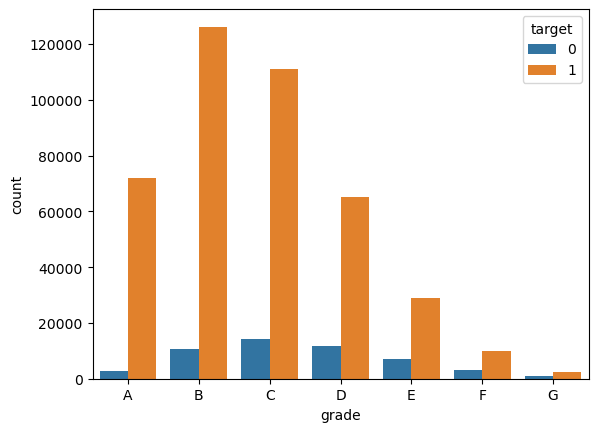

In [18]:
sns.countplot(x="grade", hue="target", data=df, order=['A','B','C','D','E','F','G'])

In [19]:
df['grade'].value_counts(normalize=True)

B    0.293659
C    0.268705
D    0.164895
A    0.160561
E    0.076685
F    0.028371
G    0.007124
Name: grade, dtype: float64

From the given right-skewed distribution chart and its percentage of values, in relation to the loan grade, we could conclude that our target variable is suitable to represent the good and bad loan category.

### 6.2. Feature Selection

### 6.2.1. Irrelevant & Forward-Looking Values

Based on description of columns in <b>LCDataDictionary.xlsx</b>, we are dropping some columns that appears to be irrelevant or potentially bias, due to its forward-looking values in relation to target variable.

In [20]:
df.drop(columns=['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d', 
                 'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

### 6.2.2. Null Values

In [21]:
def null_table(df):
    # Count null values and calculate their percentages 
    null_values = df.isnull().sum()
    null_percent = 100 * null_values / len(df)
    
    # Append columns with high percentages of null (>80%)
    drop_null_columns = []
    for null_column, null_count in null_values.iteritems():
        if (100 * null_count / len(df)) > 80:
            drop_null_columns.append(null_column)
    
    # Assign count and percentage null-valued columns to table
    null_table = pd.concat([null_values, null_percent], axis=1)
    null_table = null_table.rename(columns = {0 : 'Null Values', 1 : 'Null Percent'})
    
    # Show data type of columns with null values
    null_table['Data Type'] = df.dtypes
        
    print("There are " + str(null_table.shape[0]) + " columns that have null values.")
    print("There are " + str(len(drop_null_columns)) + " columns with more than 80% of null values: \n", drop_null_columns)
    
    return null_table, drop_null_columns

In [22]:
null_table, drop_null_columns = null_table(df)

There are 61 columns that have null values.
There are 18 columns with more than 80% of null values: 
 ['mths_since_last_record', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']


In [23]:
null_table[null_table.iloc[:,1] != 0].sort_values('Null Percent', ascending=False).round(2)

,Null Values,Null Percent,Data Type
open_acc_6m,466285,100.00,float64
dti_joint,466285,100.00,float64
open_rv_12m,466285,100.00,float64
il_util,466285,100.00,float64
total_bal_il,466285,100.00,float64
mths_since_rcnt_il,466285,100.00,float64
open_il_24m,466285,100.00,float64
open_il_12m,466285,100.00,float64
open_il_6m,466285,100.00,float64
all_util,466285,100.00,float64


<b>Problem</b>: There are 18 columns with more than 80%.

<b>Solution</b>: For the sake of simplicity, drop the columns with more than 80% of null values.

In [24]:
# Dropped columns are column with more than 80% of null values 
df.drop(columns=drop_null_columns, inplace=True)

### 6.2.3. Filter Method

In [25]:
# Split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate categorical and numerical columns from dataframe
X_train_cat = X_train.select_dtypes(include='object').copy()
X_train_num = X_train.select_dtypes(include='number').copy()

### Chi-Squared Test

To identify the most suitable features for our binary classification model, chi-squared test is used for <u>categorical features</u>.

The Chi-Squared test is used to determine the extent of relationship or dependence between two categorical variables — in our case, one categorical input feature, and the other, a categorical target variable.

In [26]:
# Categorical features are selected based on chi-squared test
chi2_check = {}
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.merge(X_train_cat.describe().T.reset_index(), 
                  left_on ='Feature', right_on = 'index').sort_values(by = ['p-value', 'unique'])

,Feature,p-value,index,count,unique,top,freq
6,initial_list_status,0.000000,initial_list_status,373028,2,f,242325
2,verification_status,0.000000,verification_status,373028,3,Verified,134571
1,home_ownership,0.000000,home_ownership,373028,5,MORTGAGE,188739
0,grade,0.000000,grade,373028,7,B,109344
4,purpose,0.000000,purpose,373028,14,debt_consolidation,219196
5,addr_state,0.000000,addr_state,373028,50,CA,56992
3,pymnt_plan,0.000923,pymnt_plan,373028,2,n,373021
7,application_type,1.000000,application_type,373028,1,INDIVIDUAL,373028


In [27]:
# Categorical columns are selected where p-value < 0.05 or statistically significant association between X and Y
selected_cat_cols = ['initial_list_status', 'verification_status', 'home_ownership', 'grade', 'purpose', 
                     'addr_state', 'pymnt_plan']

### ANOVA F-Statistics

To identify the most suitable features for our binary classification model, ANOVA test is used for <u>numerical features</u>.

After that, we will calculate the pair-wise correlations of the selected numerical features (p < 0.05) to detect any potentially multicollinear variables.

In [28]:
# Numerical features are selected based on ANOVA F test
F_statistic, p_values = f_classif(X_train_num.fillna(X_train_num.median()), y_train)
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 
                                     'F-Score': F_statistic, 
                                     'p values': p_values.round(decimals=10)}).sort_values(by=['F-Score'], ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [29]:
ANOVA_F_table.reset_index().rename(columns={"index":"No."})

,No.,Numerical_Feature,F-Score,p values
0,32,mths_since_last_pymnt_d,23229.805323,0.000000e+00
1,20,total_pymnt_inv,14784.534040,0.000000e+00
2,19,total_pymnt,14686.729567,0.000000e+00
3,4,int_rate,11462.788313,0.000000e+00
4,22,last_pymnt_amnt,10826.949727,0.000000e+00
5,17,out_prncp,9635.116160,0.000000e+00
6,18,out_prncp_inv,9633.442129,0.000000e+00
7,33,mths_since_last_credit_pull_d,7020.223525,0.000000e+00
8,31,mths_since_issue_d,2816.028871,0.000000e+00
9,10,inq_last_6mths,2003.653988,0.000000e+00


In [30]:
# Select temporary numerical features where p-value < 0.05
temp_selected_num_cols = ANOVA_F_table.iloc[:24,0].to_list()

<AxesSubplot:>

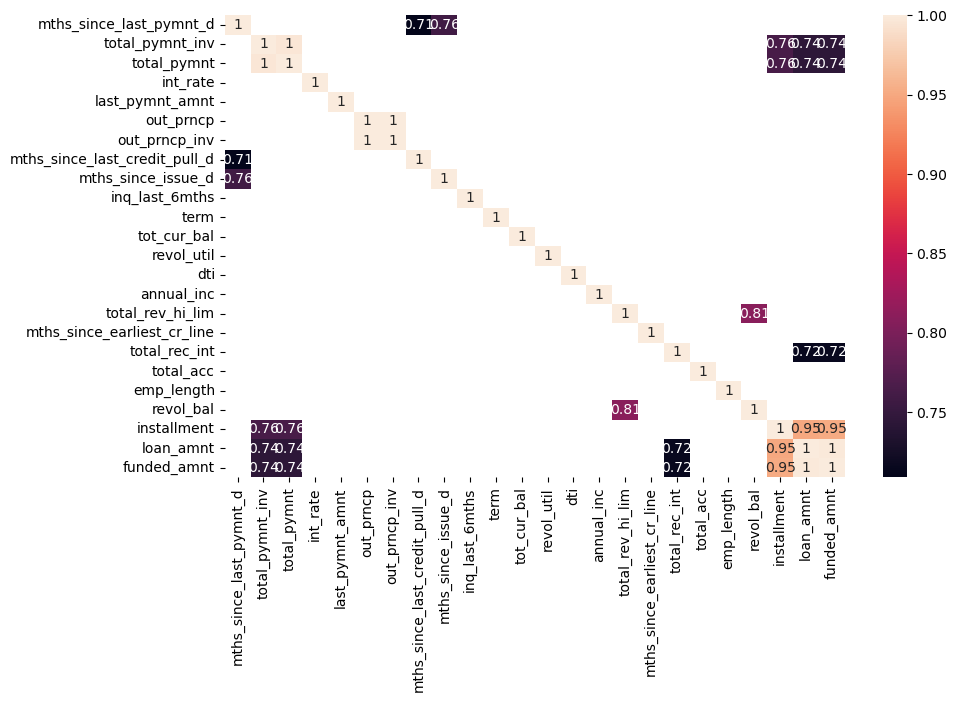

In [31]:
# Calculate the pair-wise correlations
corr_mat = X_train_num[temp_selected_num_cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_mat, annot=True, mask = (abs(corr_mat) <= 0.7))

In [32]:
# Drop the temporarily selected numerical columns based on pair-wise correlation matrix result
dropped_num_cols = ['mths_since_last_pymnt_d','mths_since_last_credit_pull_d','mths_since_issue_d',
                    'total_pymnt', 'total_pymnt_inv', 'installment','funded_amnt', 'funded_amnt_inv',
                    'out_prncp_inv',
                    'total_rev_hi_lim']
selected_num_cols = []
for col in temp_selected_num_cols:
    if col not in dropped_num_cols:
        selected_num_cols.append(col)

### 6.3. Feature Engineering

In [33]:
selected_cols = selected_cat_cols + selected_num_cols
X_train = X_train[selected_cols]

### 6.3.1. WoE/IV Binning

We discretize (or bin) the income category into discrete classes (with different WoE), to classify potential new borrowers into their respective categories. Information value (IV) is sum of the differences of percentages of good and bad customers times weight of evidence (WoE). 

In [34]:
# Create IV table and select the important variables in a predictive model.
pd.DataFrame({'No.': [1,2,3,4,5],
              'Information Value': ['< 0.02', '0.02 - 0.1', '0.1 - 0.3', '0.3 - 0.5', '> 0.5'],
              'Variable Predictiveness' : ['Not useful for prediction',
                                           'Weak predictive power',
                                           'Medium Predictive Power',
                                           'Strong predictive power',
                                           'Suspicious predictive power']}).style.hide_index()

No.,Information Value,Variable Predictiveness
1,< 0.02,Not useful for prediction
2,0.02 - 0.1,Weak predictive power
3,0.1 - 0.3,Medium Predictive Power
4,0.3 - 0.5,Strong predictive power
5,> 0.5,Suspicious predictive power


### Categorical Features

In [35]:
X_train[selected_cat_cols].describe()

,initial_list_status,verification_status,home_ownership,grade,purpose,addr_state,pymnt_plan
count,373028,373028,373028,373028,373028,373028,373028
unique,2,3,5,7,14,50,2
top,f,Verified,MORTGAGE,B,debt_consolidation,CA,n
freq,242325,134571,188739,109344,219196,56992,373021


In [36]:
# Show unique values for selected categorical columns
for cat_col in selected_cat_cols:
    print(cat_col) 
    print(X_train[cat_col].unique())

initial_list_status
['w' 'f']
verification_status
['Source Verified' 'Verified' 'Not Verified']
home_ownership
['MORTGAGE' 'OWN' 'RENT' 'OTHER' 'NONE']
grade
['A' 'D' 'B' 'F' 'C' 'E' 'G']
purpose
['credit_card' 'other' 'debt_consolidation' 'car' 'home_improvement'
 'small_business' 'major_purchase' 'house' 'medical' 'vacation' 'wedding'
 'moving' 'educational' 'renewable_energy']
addr_state
['WI' 'TN' 'WA' 'FL' 'IL' 'TX' 'NY' 'WV' 'AL' 'NV' 'MD' 'VA' 'CA' 'NH'
 'DE' 'OH' 'NJ' 'NC' 'NM' 'AZ' 'CO' 'MA' 'UT' 'GA' 'OR' 'SC' 'PA' 'IN'
 'OK' 'MN' 'HI' 'MI' 'CT' 'AK' 'MO' 'KY' 'AR' 'DC' 'KS' 'RI' 'LA' 'WY'
 'MS' 'MT' 'SD' 'VT' 'IA' 'NE' 'ID' 'ME']
pymnt_plan
['n' 'y']


<b>Problem</b>: Compared to other categorical columns, addr_state column have relatively high cardinality.

<b>Solution</b>: Drop <code>addr_state</code> column

In [37]:
# Drop addr_state column
selected_cat_cols.remove('addr_state')
X_train.drop(columns=['addr_state'], inplace=True)
X_test.drop(columns=['addr_state'], inplace=True)

In [38]:
X_train['initial_list_status'].value_counts(normalize=True)

f    0.649616
w    0.350384
Name: initial_list_status, dtype: float64

In [39]:
X_train['verification_status'].value_counts(normalize=True)

Verified           0.360753
Source Verified    0.321609
Not Verified       0.317638
Name: verification_status, dtype: float64

In [40]:
X_train['home_ownership'].value_counts(normalize=True)

MORTGAGE    0.505965
RENT        0.404195
OWN         0.089304
OTHER       0.000426
NONE        0.000110
Name: home_ownership, dtype: float64

In [41]:
X_train['grade'].value_counts(normalize=True)

B    0.293125
C    0.268993
D    0.165438
A    0.160336
E    0.076643
F    0.028432
G    0.007032
Name: grade, dtype: float64

In [42]:
X_train['purpose'].value_counts(normalize=True)

debt_consolidation    0.587613
credit_card           0.223385
home_improvement      0.056974
other                 0.050951
major_purchase        0.021106
small_business        0.015026
car                   0.011383
medical               0.010053
moving                0.006426
vacation              0.005370
wedding               0.005093
house                 0.004890
educational           0.000941
renewable_energy      0.000791
Name: purpose, dtype: float64

In [43]:
X_train['pymnt_plan'].value_counts(normalize=True)

n    0.999981
y    0.000019
Name: pymnt_plan, dtype: float64

<b>Problem</b>: <code>pymnt_plan</code> column have imbalanced data.

<b>Solution</b>: Drop <code>pymnt_plan</code> column

In [44]:
# Drop addr_state column
selected_cat_cols.remove('pymnt_plan')
X_train.drop(columns=['pymnt_plan'], inplace=True)
X_test.drop(columns=['pymnt_plan'], inplace=True)

In [45]:
sns.set()
def woe_discrete(df, cat_col, y_df):
    '''Function to calculate WoE and IV of categorical features'''
    
    df = pd.concat([df[cat_col], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    
    plt.figure(figsize=(18, 6))
    x = np.array(df.iloc[:, 0].apply(str))
    y = df['WoE']
    sns.lineplot(x = x, y = y, marker = 'o', linestyle = ':', color = 'k')
    plt.xlabel(df.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df.columns[0]))
    plt.xticks(rotation = 0)
    plt.show()
    
    return df

#### INITIAL_LIST_STATUS
The initial listing status of the loan. Possible values are – Whole (w), Fractional (f)

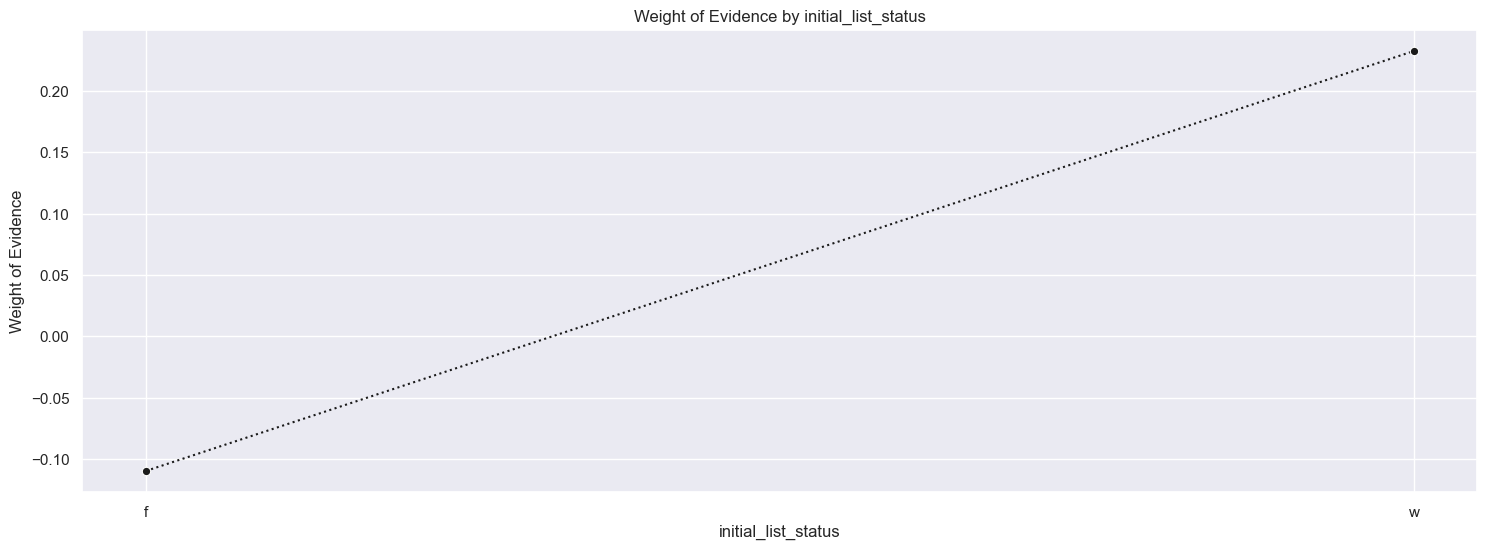

,initial_list_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,f,242325,0.879550,0.649616,213137.0,29188.0,0.641488,0.715848,-0.109678,NaN,NaN,0.025441
1,w,130703,0.911356,0.350384,119117.0,11586.0,0.358512,0.284152,0.232454,0.031806,0.342131,0.025441


In [46]:
woe_discrete(X_train,'initial_list_status', y_train)

#### VERIFICATION_STATUS
Indicates if the borrower's income was verified, not verified, or if the income source was verified by LC.

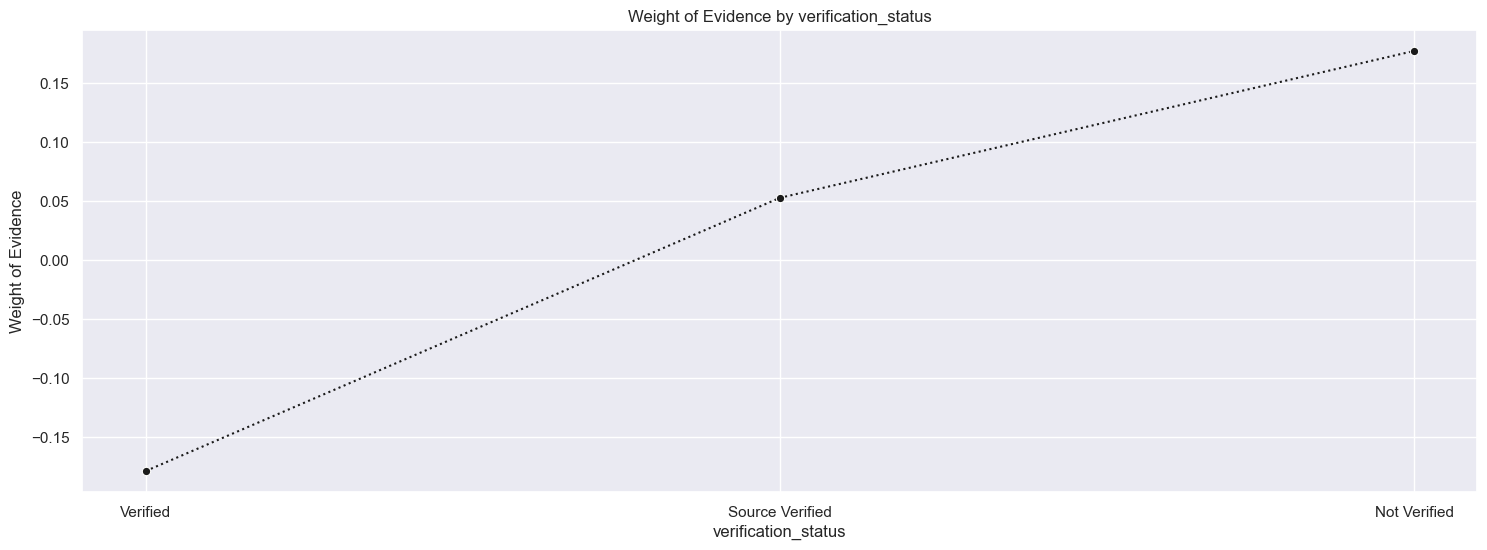

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,134571,0.872045,0.360753,117352.0,17219.0,0.353200,0.422303,-0.178691,NaN,NaN,0.022522
1,Source Verified,119969,0.895723,0.321609,107459.0,12510.0,0.323424,0.306813,0.052726,0.023678,0.231417,0.022522
2,Not Verified,118488,0.906784,0.317638,107443.0,11045.0,0.323376,0.270883,0.177128,0.011061,0.124402,0.022522


In [47]:
woe_discrete(X_train,'verification_status', y_train)

#### HOME_OWNERSHIP
The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

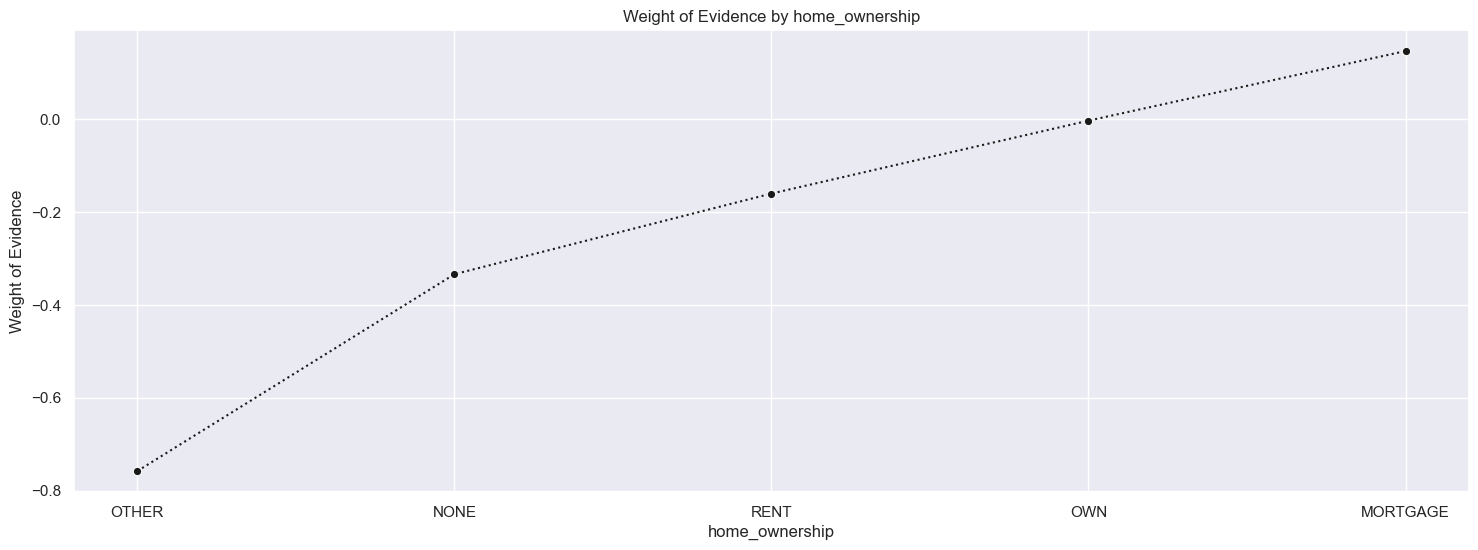

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,159,0.792453,0.000426,126.0,33.0,0.000379,0.000809,-0.758081,NaN,NaN,0.02166
1,NONE,41,0.853659,0.000110,35.0,6.0,0.000105,0.000147,-0.334267,0.061206,0.423814,0.02166
2,RENT,150776,0.874052,0.404195,131786.0,18990.0,0.396642,0.465738,-0.160588,0.020393,0.173678,0.02166
3,OWN,33313,0.890343,0.089304,29660.0,3653.0,0.089269,0.089591,-0.003605,0.016292,0.156984,0.02166
4,MORTGAGE,188739,0.904143,0.505965,170647.0,18092.0,0.513604,0.443714,0.146272,0.013800,0.149877,0.02166


In [48]:
woe_discrete(X_train,'home_ownership', y_train)

#### GRADE
LC assigned loan grade.

The letter grades that are assigned to loans indicate the expected risk of the loan. Loans graded A have the lowest expected risk of loss and therefore pay the lender the lowest interest rate. On the other hand, G loans have the highest expected risk of loss. Accordingly, G loans pay the highest interest rate in order to compensate lenders for the increased risk relative to an A loan.

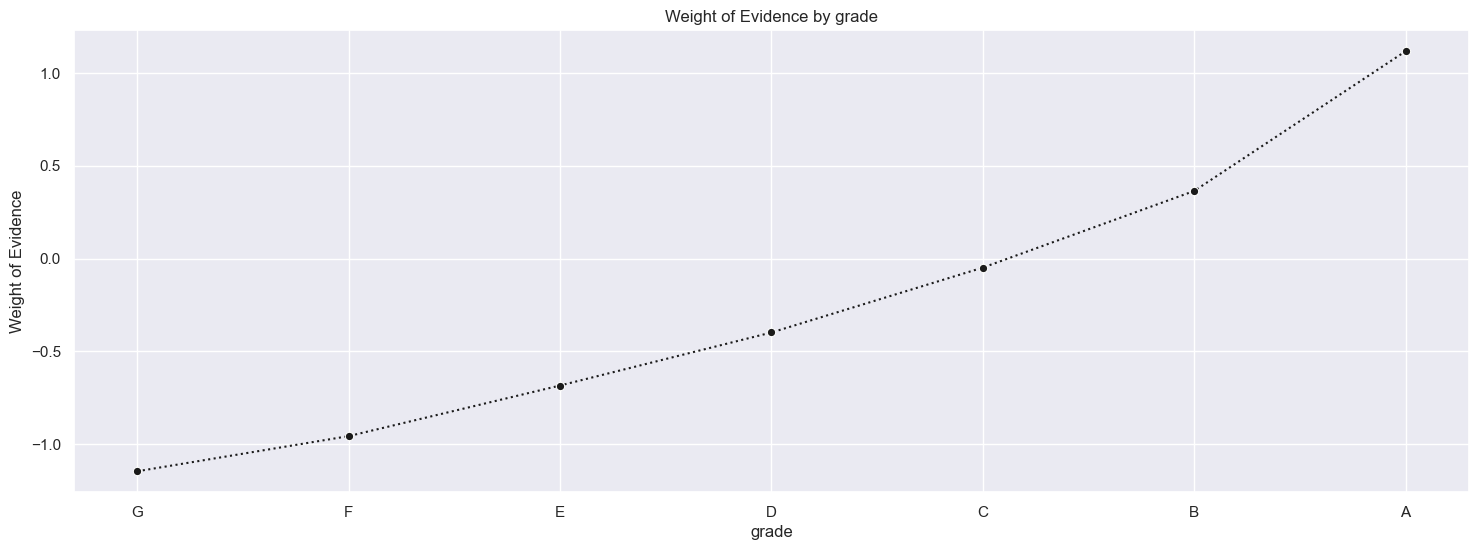

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904,-1.144981,NaN,NaN,0.292145
1,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932,-0.955774,0.036369,0.189207,0.292145
2,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097,-0.683340,0.046416,0.272434,0.292145
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801,-0.397915,0.041050,0.285425,0.292145
4,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865,-0.048620,0.040343,0.349295,0.292145
5,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723,0.363975,0.035552,0.412595,0.292145
6,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678,1.116232,0.039939,0.752257,0.292145


In [49]:
woe_discrete(X_train,'grade', y_train)

#### PURPOSE
A category provided by the borrower for the loan request. 

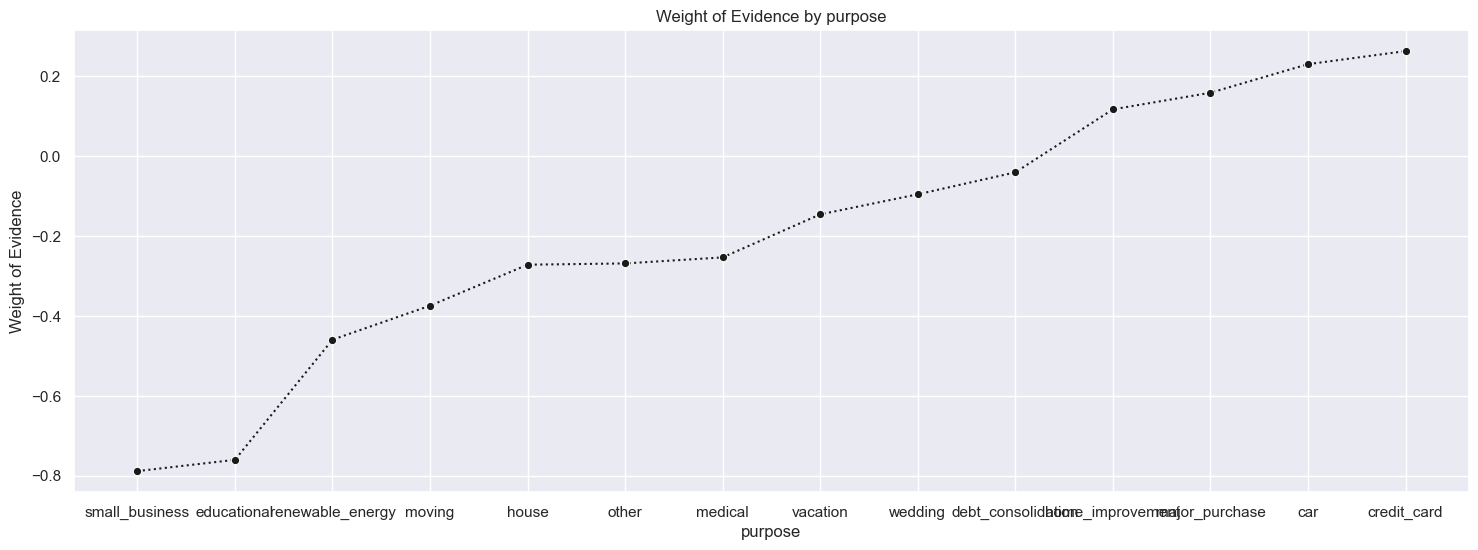

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,small_business,5605,0.787333,0.015026,4413.0,1192.0,0.013282,0.029234,-0.788933,NaN,NaN,0.036668
1,educational,351,0.792023,0.000941,278.0,73.0,0.000837,0.001790,-0.760693,0.004690,0.028240,0.036668
2,renewable_energy,295,0.837288,0.000791,247.0,48.0,0.000743,0.001177,-0.459668,0.045265,0.301026,0.036668
3,moving,2397,0.848561,0.006426,2034.0,363.0,0.006122,0.008903,-0.374498,0.011273,0.085169,0.036668
4,house,1824,0.861294,0.004890,1571.0,253.0,0.004728,0.006205,-0.271777,0.012733,0.102721,0.036668
5,other,19006,0.861675,0.050951,16377.0,2629.0,0.049291,0.064477,-0.268581,0.000381,0.003196,0.036668
6,medical,3750,0.863467,0.010053,3238.0,512.0,0.009746,0.012557,-0.253469,0.001791,0.015112,0.036668
7,vacation,2003,0.875686,0.005370,1754.0,249.0,0.005279,0.006107,-0.145654,0.012220,0.107815,0.036668
8,wedding,1900,0.881053,0.005093,1674.0,226.0,0.005038,0.005543,-0.095419,0.005366,0.050235,0.036668
9,debt_consolidation,219196,0.886704,0.587613,194362.0,24834.0,0.584980,0.609065,-0.040346,0.005652,0.055072,0.036668


In [50]:
woe_discrete(X_train,'purpose', y_train)

### Numerical Features

In [51]:
X_train[selected_num_cols].nunique().sort_values(ascending=False)

total_rec_int                  231352
tot_cur_bal                    192158
last_pymnt_amnt                166607
out_prncp                      112954
revol_bal                       54731
annual_inc                      26981
dti                              3997
loan_amnt                        1349
revol_util                       1242
mths_since_earliest_cr_line       515
int_rate                          503
total_acc                         112
inq_last_6mths                     28
emp_length                         11
term                                2
dtype: int64

In [52]:
# Check for missing values in numerical features
X_train[selected_num_cols].isnull().sum()

int_rate                           0
last_pymnt_amnt                    0
out_prncp                          0
inq_last_6mths                    25
term                               0
tot_cur_bal                    56156
revol_util                       264
dti                                0
annual_inc                         4
mths_since_earliest_cr_line       25
total_rec_int                      0
total_acc                         25
emp_length                         0
revol_bal                          0
loan_amnt                          0
dtype: int64

In [53]:
# Impute the missing values from numerical columns with its median
my_imputer = SimpleImputer(strategy='median')
X_train[selected_num_cols] = my_imputer.fit_transform(X_train[selected_num_cols])
X_test[selected_num_cols] = my_imputer.transform(X_test[selected_num_cols])

In [54]:
sns.set()
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    '''Function to calculate WoE and IV of numerical features'''
    
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    
    plt.figure(figsize=(18, 6))
    x = np.array(df.iloc[:, 0].apply(str))
    y = df['WoE']
    sns.lineplot(x = x, y = y, marker = 'o', linestyle = ':', color = 'k')
    plt.xlabel(df.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df.columns[0]))
    plt.xticks(rotation = 0)
    plt.show()
    
    return df

<b>Problem:</b> Some selected numerical features have high dimentionality (>20 unique values).

<b>Solution:</b> Apply binning to numerical features with high dimentionality.

#### TERM
The number of payments on the loan. Values are in months and can be either 36 or 60. 

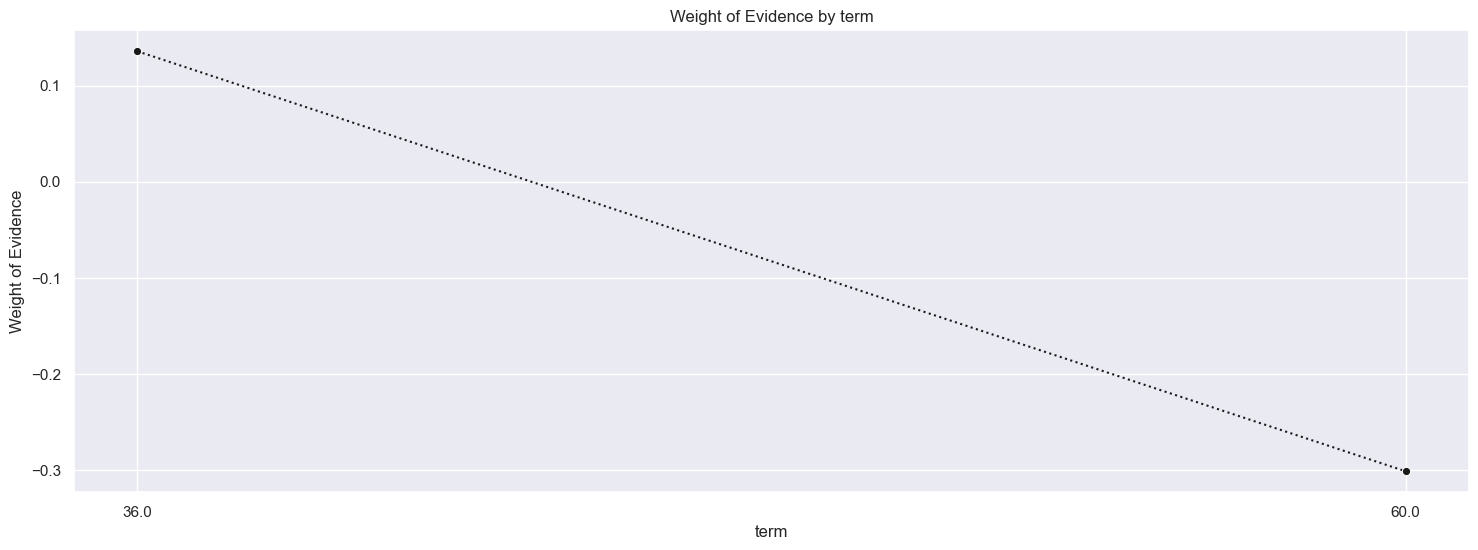

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36.0,270199,0.903238,0.72434,244054.0,26145.0,0.73454,0.641217,0.135876,NaN,NaN,0.040794
1,60.0,102829,0.857735,0.27566,88200.0,14629.0,0.26546,0.358783,-0.301254,0.045503,0.43713,0.040794


In [55]:
woe_ordered_continuous(X_train,'term', y_train)

#### EMP_LENGTH
Employment length in years. 

Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

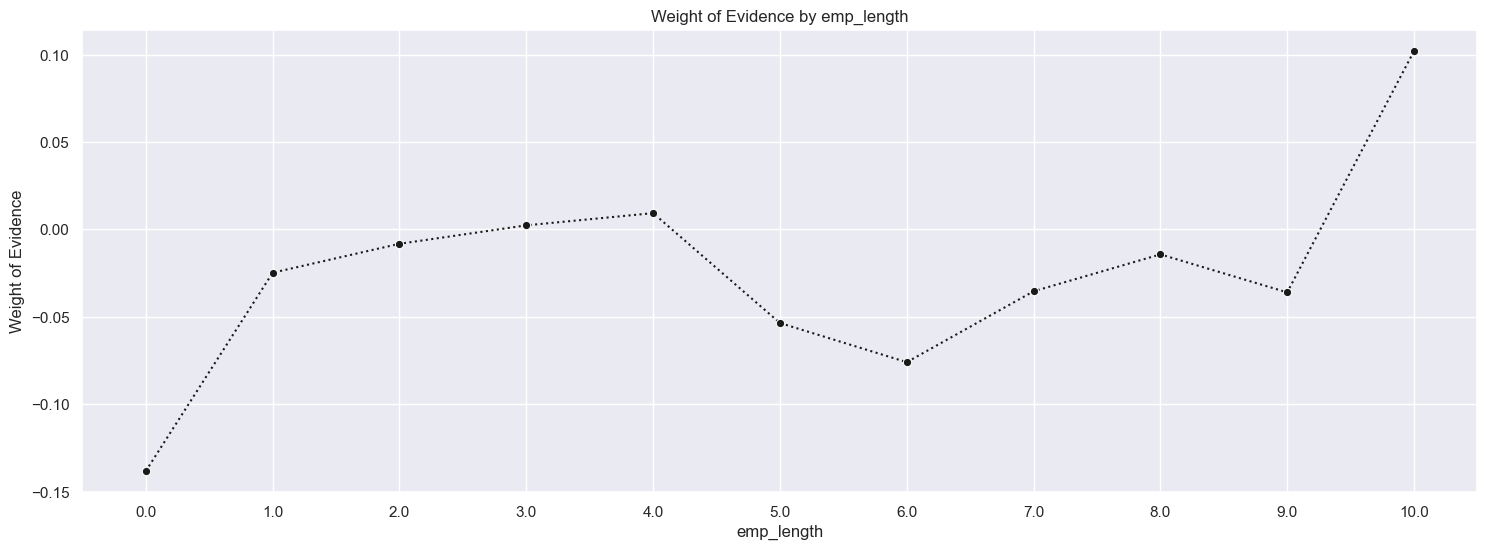

,emp_length,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,45764,0.876497,0.122682,40112.0,5652.0,0.120727,0.138618,-0.138189,NaN,NaN,0.006408
1,1.0,23582,0.888262,0.063218,20947.0,2635.0,0.063045,0.064625,-0.024743,0.011765,0.113446,0.006408
2,2.0,33123,0.889895,0.088795,29476.0,3647.0,0.088715,0.089444,-0.008184,0.001633,0.016559,0.006408
3,3.0,29301,0.890925,0.078549,26105.0,3196.0,0.078569,0.078383,0.002372,0.001030,0.010555,0.006408
4,4.0,22482,0.891602,0.060269,20045.0,2437.0,0.060330,0.059768,0.009357,0.000677,0.006985,0.006408
5,5.0,24654,0.885374,0.066092,21828.0,2826.0,0.065697,0.069309,-0.053524,0.006229,0.062881,0.006408
6,6.0,21057,0.883079,0.056449,18595.0,2462.0,0.055966,0.060382,-0.075936,0.002294,0.022413,0.006408
7,7.0,20834,0.887204,0.055851,18484.0,2350.0,0.055632,0.057635,-0.035365,0.004124,0.040571,0.006408
8,8.0,17859,0.889300,0.047876,15882.0,1977.0,0.047801,0.048487,-0.014249,0.002096,0.021116,0.006408
9,9.0,14372,0.887142,0.038528,12750.0,1622.0,0.038374,0.039780,-0.035984,0.002158,0.021735,0.006408


In [56]:
woe_ordered_continuous(X_train,'emp_length', y_train)

<b>Problem:</b> <code>emp_length</code> column have a low IV value.

<b>Solution:</b> Drop the <code>emp_length</code> column.

#### INQ_LAST_6MTHS
The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

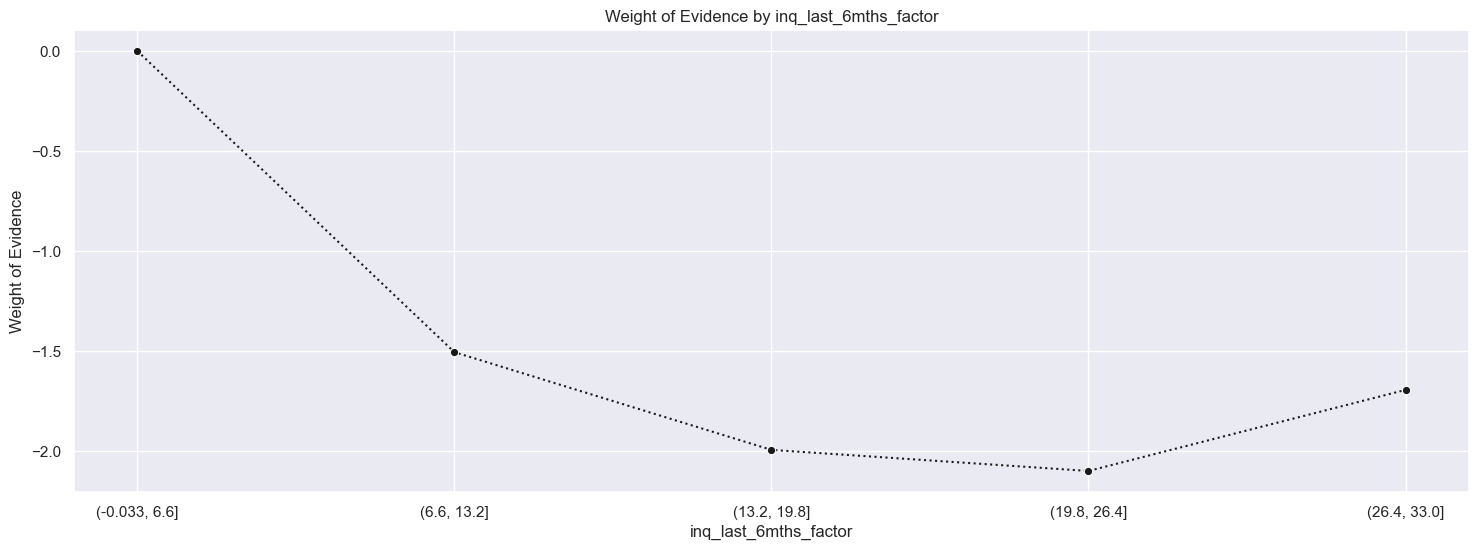

,inq_last_6mths_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.033, 6.6]",372657,0.890948,0.999005,332018.0,40639.0,0.999290,0.996689,0.002606,NaN,NaN,0.004044
1,"(6.6, 13.2]",343,0.644315,0.000920,221.0,122.0,0.000665,0.002992,-1.503713,0.246633,1.506319,0.004044
2,"(13.2, 19.8]",19,0.526316,0.000051,10.0,9.0,0.000030,0.000221,-1.992495,0.117999,0.488781,0.004044
3,"(19.8, 26.4]",4,0.500000,0.000011,2.0,2.0,0.000006,0.000049,-2.097855,0.026316,0.105361,0.004044
4,"(26.4, 33.0]",5,0.600000,0.000013,3.0,2.0,0.000009,0.000049,-1.692390,0.100000,0.405465,0.004044


In [57]:
# Convert numerical features with high cardinality into bins.
X_train['inq_last_6mths_factor'] = pd.cut(X_train['inq_last_6mths'], 5)
woe_ordered_continuous(X_train,'inq_last_6mths_factor', y_train)

<b>Problem:</b> <code>inq_last_6mths</code> column have a low IV value.

<b>Solution:</b> Drop the <code>inq_last_6mths</code> column.

#### TOTAL_ACC
The total number of credit lines currently in the borrower's credit file

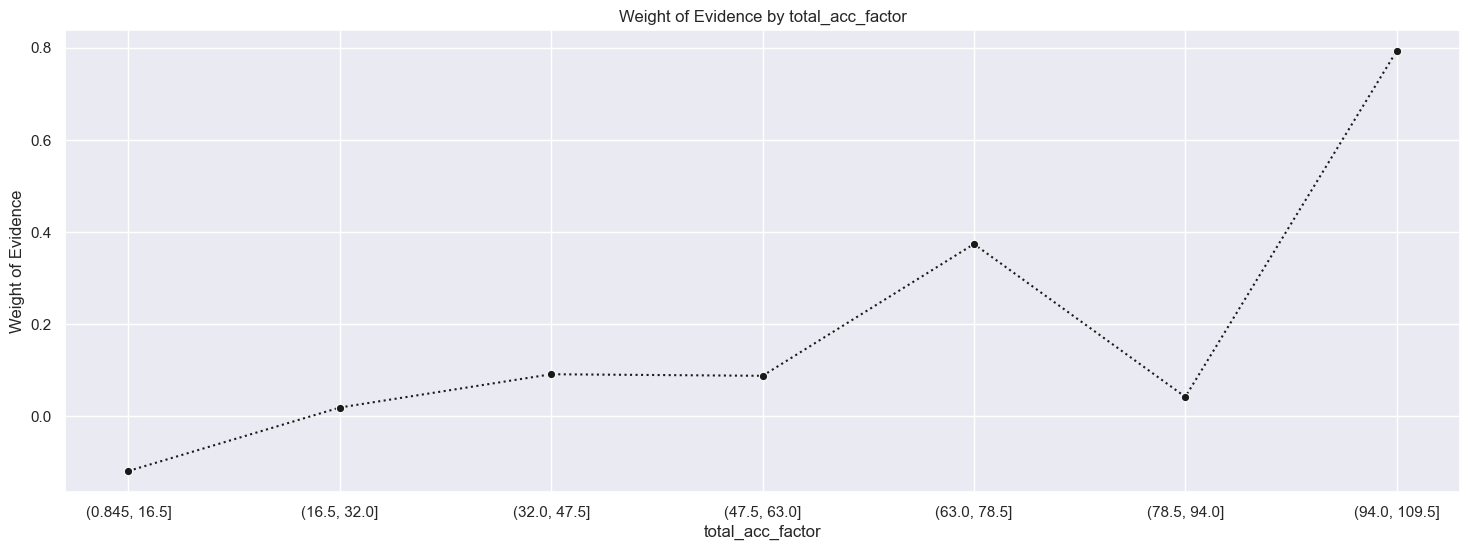

,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.845, 16.5]",92599,0.878606,0.248236,81358.0,11241.0,0.244867,0.275690,-0.118564,NaN,NaN,inf
1,"(16.5, 32.0]",193122,0.892539,0.517714,172369.0,20753.0,0.518787,0.508976,0.019092,0.013934,0.137655,inf
2,"(32.0, 47.5]",70662,0.899267,0.189428,63544.0,7118.0,0.191251,0.174572,0.091251,0.006728,0.072159,inf
3,"(47.5, 63.0]",15657,0.898959,0.041973,14075.0,1582.0,0.042362,0.038799,0.087855,0.000308,0.003395,inf
4,"(63.0, 78.5]",809,0.922126,0.002169,746.0,63.0,0.002245,0.001545,0.373736,0.023167,0.285881,inf
5,"(78.5, 94.0]",152,0.894737,0.000407,136.0,16.0,0.000409,0.000392,0.042211,0.027389,0.331525,inf
6,"(94.0, 109.5]",19,0.947368,0.000051,18.0,1.0,0.000054,0.000025,0.792517,0.052632,0.750306,inf
7,"(109.5, 125.0]",6,1.000000,0.000016,6.0,0.0,0.000018,0.000000,inf,0.052632,inf,inf
8,"(125.0, 140.5]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(140.5, 156.0]",2,1.000000,0.000005,2.0,0.0,0.000006,0.000000,inf,NaN,NaN,inf


In [58]:
# Convert numerical features with high cardinality into bins.
X_train['total_acc_factor'] = pd.cut(X_train['total_acc'], 10)
woe_ordered_continuous(X_train,'total_acc_factor', y_train)

<b>Problem:</b> <code>total_acc</code> column have extreme values.

<b>Solution:</b> Replace the values with median.

In [59]:
median = X_train.loc[X_train['total_acc'] < 94, 'total_acc'].median()
X_train['total_acc'] = np.where(X_train['total_acc'] > 94, median, X_train['total_acc'])

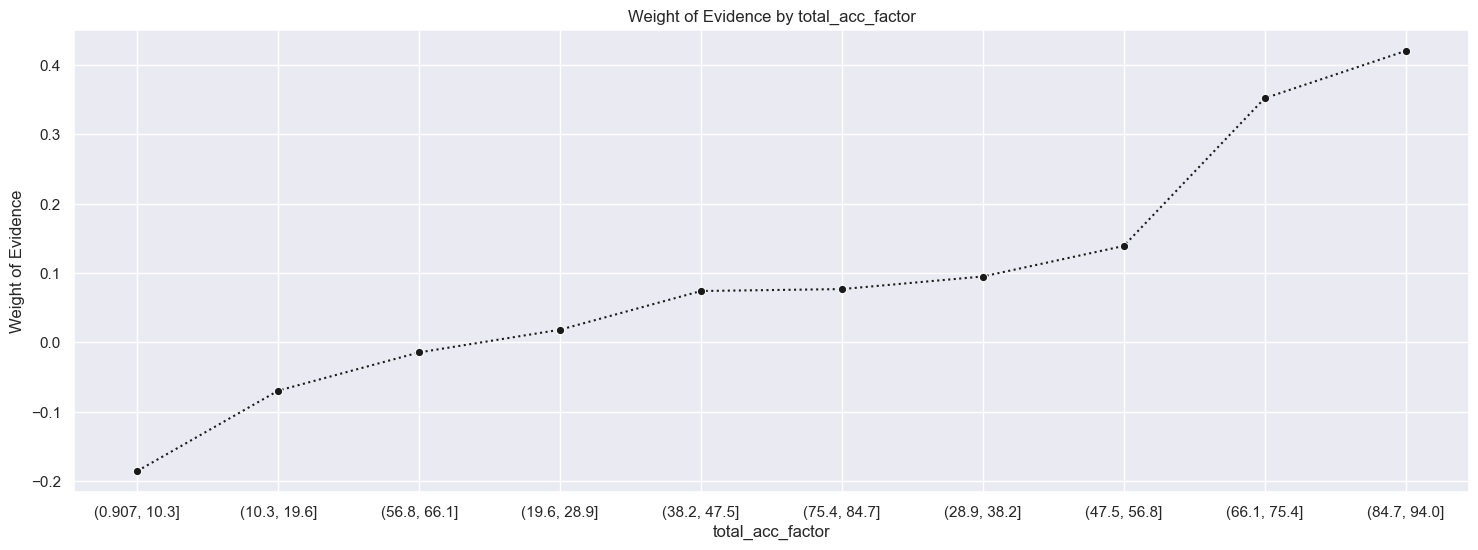

,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.907, 10.3]",28694,0.871332,0.076922,25002.0,3692.0,0.075250,0.090548,-0.185068,NaN,NaN,0.007291
1,"(10.3, 19.6]",103532,0.883756,0.277545,91497.0,12035.0,0.275383,0.295164,-0.069368,0.012424,0.115700,0.007291
2,"(56.8, 66.1]",4634,0.889297,0.012423,4121.0,513.0,0.012403,0.012582,-0.014280,0.005541,0.055088,0.007291
3,"(19.6, 28.9]",115030,0.892472,0.308368,102661.0,12369.0,0.308983,0.303355,0.018384,0.003175,0.032664,0.007291
4,"(38.2, 47.5]",30842,0.897704,0.082680,27687.0,3155.0,0.083331,0.077378,0.074119,0.005233,0.055736,0.007291
5,"(75.4, 84.7]",147,0.897959,0.000394,132.0,15.0,0.000397,0.000368,0.076897,0.000255,0.002777,0.007291
6,"(28.9, 38.2]",78312,0.899607,0.209936,70450.0,7862.0,0.212037,0.192819,0.095007,0.001648,0.018110,0.007291
7,"(47.5, 56.8]",11317,0.903508,0.030338,10225.0,1092.0,0.030775,0.026782,0.138970,0.003901,0.043963,0.007291
8,"(66.1, 75.4]",453,0.920530,0.001214,417.0,36.0,0.001255,0.000883,0.351712,0.017022,0.212742,0.007291
9,"(84.7, 94.0]",67,0.925373,0.000180,62.0,5.0,0.000187,0.000123,0.419841,0.004843,0.068129,0.007291


In [60]:
X_train['total_acc_factor'] = pd.cut(X_train['total_acc'], 10)
woe_discrete(X_train,'total_acc_factor', y_train)

<b>Problem:</b> <code>total_acc</code> column have a low IV value.

<b>Solution:</b> Drop the <code>total_acc</code> column.

#### INT_RATE
Interest Rate on the loan.

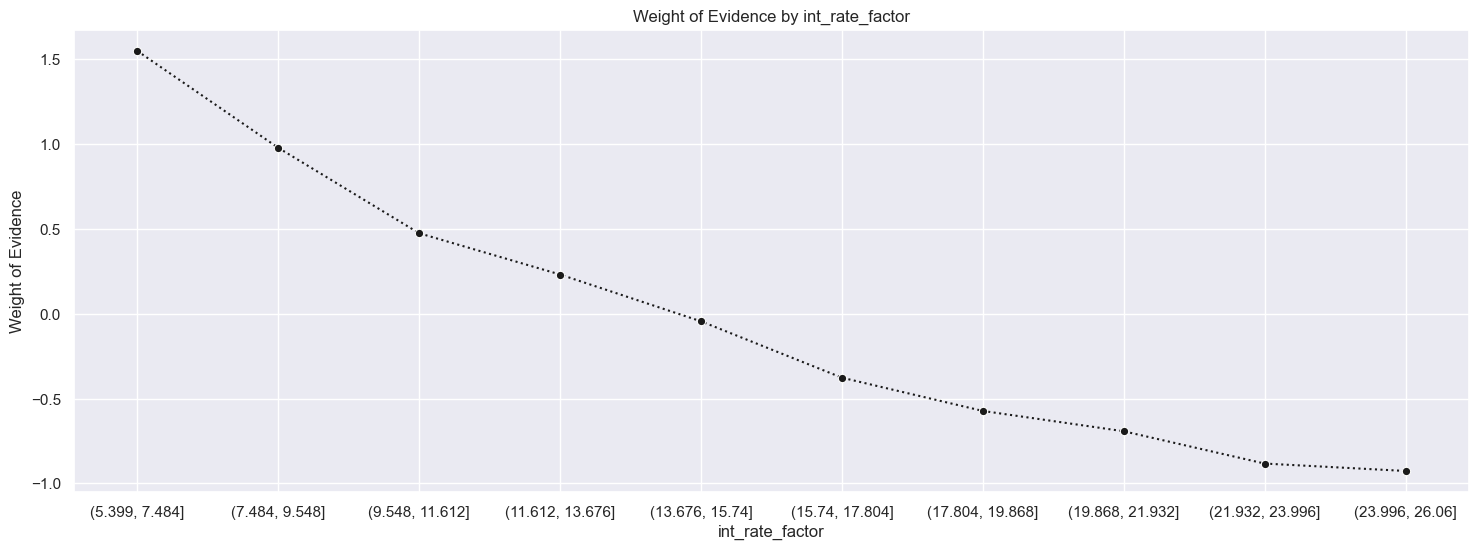

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.399, 7.484]",21989,0.974578,0.058947,21430.0,559.0,0.064499,0.013710,1.548543,NaN,NaN,0.328841
1,"(7.484, 9.548]",45077,0.955876,0.120841,43088.0,1989.0,0.129684,0.048781,0.977757,0.018703,0.570785,0.328841
2,"(9.548, 11.612]",46863,0.929049,0.125629,43538.0,3325.0,0.131038,0.081547,0.474309,0.026827,0.503448,0.328841
3,"(11.612, 13.676]",75686,0.911252,0.202896,68969.0,6717.0,0.207579,0.164737,0.231160,0.017797,0.243149,0.328841
4,"(13.676, 15.74]",70129,0.886267,0.187999,62153.0,7976.0,0.187065,0.195615,-0.044693,0.024985,0.275853,0.328841
5,"(15.74, 17.804]",48557,0.848261,0.130170,41189.0,7368.0,0.123968,0.180703,-0.376830,0.038006,0.332137,0.328841
6,"(17.804, 19.868]",30360,0.821278,0.081388,24934.0,5426.0,0.075045,0.133075,-0.572825,0.026983,0.195995,0.328841
7,"(19.868, 21.932]",15854,0.803015,0.042501,12731.0,3123.0,0.038317,0.076593,-0.692609,0.018263,0.119784,0.328841
8,"(21.932, 23.996]",11502,0.771170,0.030834,8870.0,2632.0,0.026696,0.064551,-0.882924,0.031845,0.190315,0.328841
9,"(23.996, 26.06]",7011,0.763372,0.018795,5352.0,1659.0,0.016108,0.040688,-0.926600,0.007798,0.043675,0.328841


In [61]:
# Convert numerical features with high cardinality into bins.
X_train['int_rate_factor'] = pd.cut(X_train['int_rate'], 10)
woe_ordered_continuous(X_train,'int_rate_factor', y_train)

#### MTHS_SINCE_EARLIEST_CR_LINE

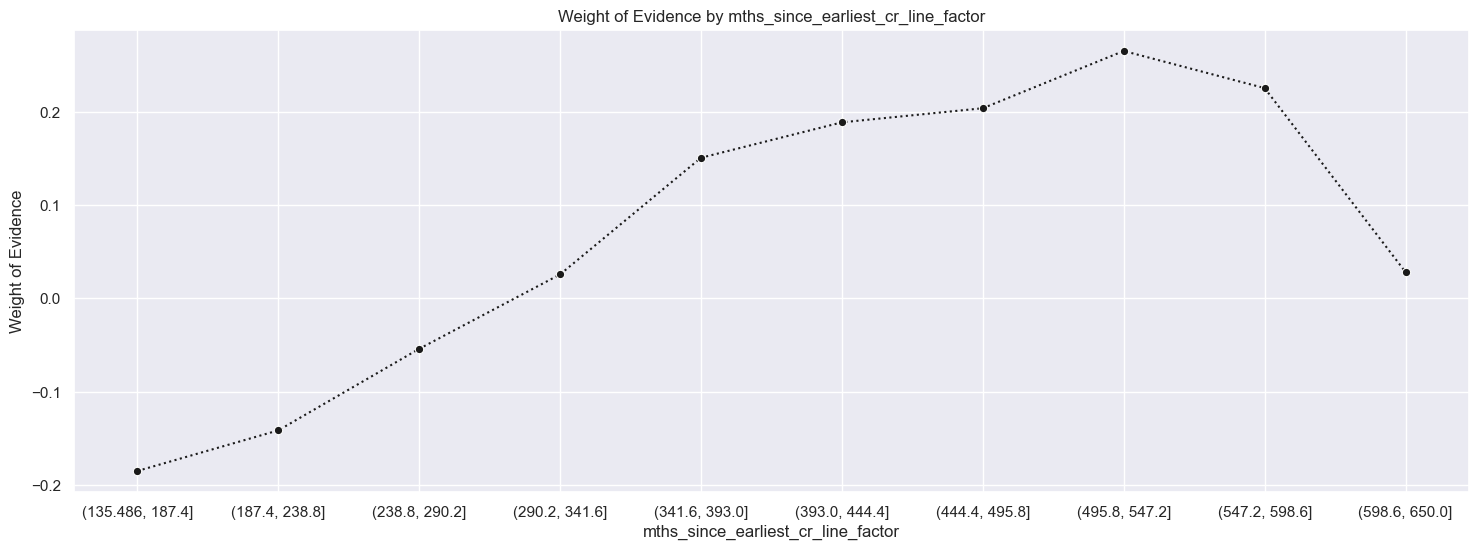

,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(135.486, 187.4]",15782,0.871372,0.042308,13752.0,2030.0,0.041390,0.049787,-0.184707,NaN,NaN,0.01439
1,"(187.4, 238.8]",63294,0.876165,0.169676,55456.0,7838.0,0.166908,0.192230,-0.141249,0.004793,0.043458,0.01439
2,"(238.8, 290.2]",111130,0.885332,0.297913,98387.0,12743.0,0.296120,0.312528,-0.053929,0.009167,0.087320,0.01439
3,"(290.2, 341.6]",81228,0.893177,0.217753,72551.0,8677.0,0.218360,0.212807,0.025759,0.007845,0.079687,0.01439
4,"(341.6, 393.0]",46031,0.904521,0.123398,41636.0,4395.0,0.125314,0.107789,0.150643,0.011344,0.124884,0.01439
5,"(393.0, 444.4]",27674,0.907747,0.074187,25121.0,2553.0,0.075608,0.062613,0.188580,0.003226,0.037937,0.01439
6,"(444.4, 495.8]",14803,0.909005,0.039683,13456.0,1347.0,0.040499,0.033036,0.203690,0.001258,0.015110,0.01439
7,"(495.8, 547.2]",6996,0.913951,0.018755,6394.0,602.0,0.019244,0.014764,0.265003,0.004946,0.061313,0.01439
8,"(547.2, 598.6]",3463,0.910771,0.009283,3154.0,309.0,0.009493,0.007578,0.225230,0.003180,0.039772,0.01439
9,"(598.6, 650.0]",2627,0.893415,0.007042,2347.0,280.0,0.007064,0.006867,0.028248,0.017356,0.196982,0.01439


In [62]:
# Convert numerical features with high cardinality into bins.
X_train['mths_since_earliest_cr_line_factor'] = pd.cut(X_train['mths_since_earliest_cr_line'], 10)
woe_ordered_continuous(X_train,'mths_since_earliest_cr_line_factor', y_train)

<b>Problem:</b> <code>mths_since_earliest_cr_line</code> column have a low IV value.

<b>Solution:</b> Drop the <code>mths_since_earliest_cr_line</code> column.

#### REVOL_UTIL
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

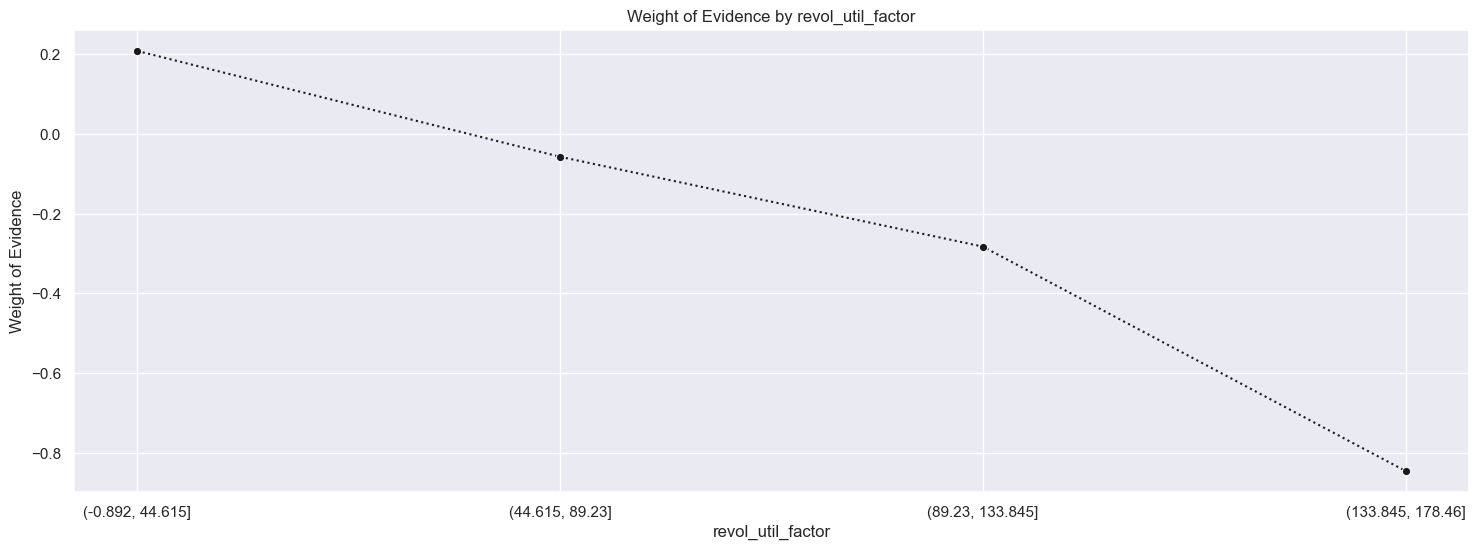

,revol_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.892, 44.615]",117757,0.909347,0.315679,107082.0,10675.0,0.322290,0.261809,0.207835,NaN,NaN,inf
1,"(44.615, 89.23]",225804,0.884975,0.605327,199831.0,25973.0,0.601440,0.636999,-0.057441,0.024372,0.265276,inf
2,"(89.23, 133.845]",29456,0.859995,0.078965,25332.0,4124.0,0.076243,0.101143,-0.282610,0.024981,0.225170,inf
3,"(133.845, 178.46]",9,0.777778,0.000024,7.0,2.0,0.000021,0.000049,-0.845092,0.082217,0.562482,inf
4,"(178.46, 223.075]",1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.222222,inf,inf
5,"(223.075, 267.69]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
6,"(267.69, 312.305]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
7,"(312.305, 356.92]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(356.92, 401.535]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(401.535, 446.15]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [63]:
# Convert numerical features with high cardinality into bins.
X_train['revol_util_factor'] = pd.cut(X_train['revol_util'], 20)
woe_ordered_continuous(X_train,'revol_util_factor', y_train)

<b>Problem:</b> <code>revol_util</code> column have extreme values.

<b>Solution:</b> Replace the values with median.

In [64]:
median = X_train.loc[X_train['revol_util'] < 115, 'revol_util'].median()
X_train['revol_util'] = np.where(X_train['revol_util'] > 115, median, X_train['revol_util'])

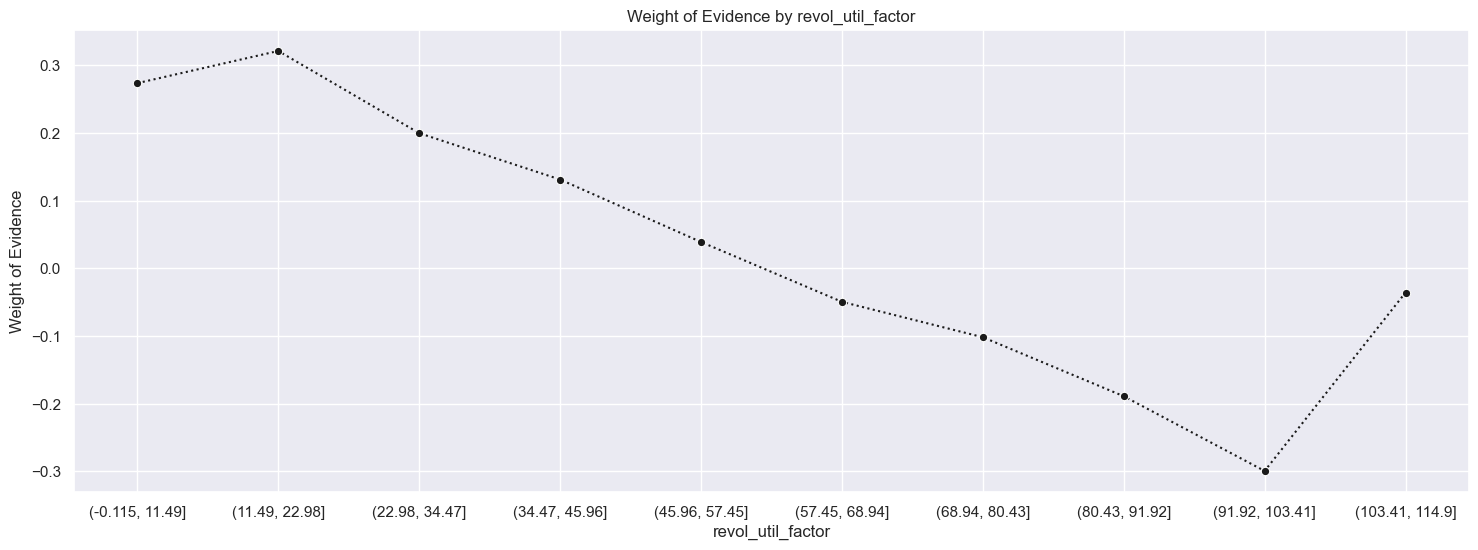

,revol_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.115, 11.49]",14644,0.914641,0.039257,13394.0,1250.0,0.040313,0.030657,0.273808,NaN,NaN,0.02627
1,"(11.49, 22.98]",21831,0.918281,0.058524,20047.0,1784.0,0.060336,0.043753,0.321366,0.003641,0.047558,0.02627
2,"(22.98, 34.47]",36788,0.908693,0.098620,33429.0,3359.0,0.100613,0.082381,0.199925,0.009588,0.121441,0.02627
3,"(34.47, 45.96]",50765,0.902846,0.136089,45833.0,4932.0,0.137946,0.120959,0.131405,0.005847,0.068521,0.02627
4,"(45.96, 57.45]",61540,0.894443,0.164974,55044.0,6496.0,0.165668,0.159317,0.039091,0.008404,0.092314,0.02627
5,"(57.45, 68.94]",64062,0.885798,0.171735,56746.0,7316.0,0.170791,0.179428,-0.049334,0.008645,0.088425,0.02627
6,"(68.94, 80.43]",58017,0.880397,0.155530,51078.0,6939.0,0.153732,0.170182,-0.101659,0.005401,0.052325,0.02627
7,"(80.43, 91.92]",45014,0.870907,0.120672,39203.0,5811.0,0.117991,0.142517,-0.188855,0.009490,0.087196,0.02627
8,"(91.92, 103.41]",20172,0.857971,0.054076,17307.0,2865.0,0.052090,0.070265,-0.299312,0.012935,0.110458,0.02627
9,"(103.41, 114.9]",195,0.887179,0.000523,173.0,22.0,0.000521,0.000540,-0.035606,0.029208,0.263706,0.02627


In [65]:
X_train['revol_util_factor'] = pd.cut(X_train['revol_util'], 10)
woe_ordered_continuous(X_train,'revol_util_factor', y_train)

#### LOAN_AMNT
The listed amount of the loan applied for by the borrower. 

If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

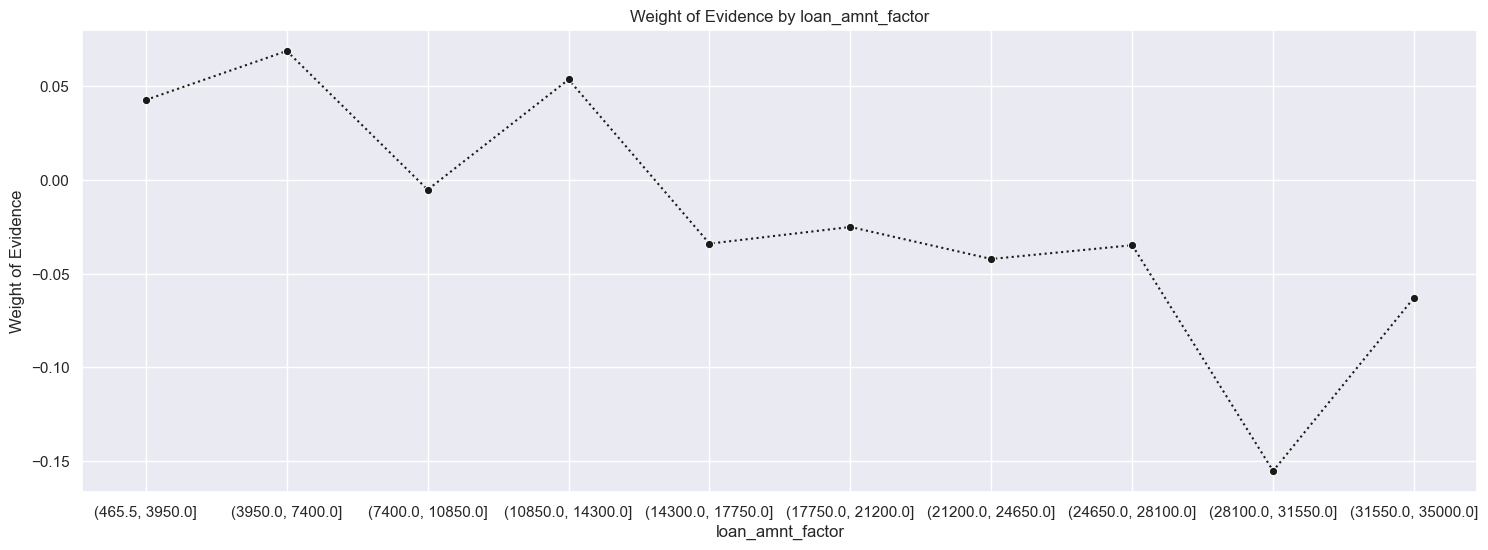

,loan_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(465.5, 3950.0]",22336,0.894789,0.059878,19986.0,2350.0,0.060153,0.057635,0.042762,NaN,NaN,0.002589
1,"(3950.0, 7400.0]",60667,0.897226,0.162634,54432.0,6235.0,0.163826,0.152916,0.068919,0.002437,0.026157,0.002589
2,"(7400.0, 10850.0]",73153,0.890189,0.196106,65120.0,8033.0,0.195995,0.197013,-0.005181,0.007037,0.074100,0.002589
3,"(10850.0, 14300.0]",52127,0.895812,0.139740,46696.0,5431.0,0.140543,0.133198,0.053680,0.005623,0.058862,0.002589
4,"(14300.0, 17750.0]",48535,0.887339,0.130111,43067.0,5468.0,0.129621,0.134105,-0.034011,0.008473,0.087691,0.002589
5,"(17750.0, 21200.0]",46505,0.888227,0.124669,41307.0,5198.0,0.124324,0.127483,-0.025097,0.000888,0.008914,0.002589
6,"(21200.0, 24650.0]",20382,0.886518,0.054639,18069.0,2313.0,0.054383,0.056727,-0.042203,0.001710,0.017106,0.002589
7,"(24650.0, 28100.0]",21305,0.887257,0.057114,18903.0,2402.0,0.056893,0.058910,-0.034836,0.000739,0.007367,0.002589
8,"(28100.0, 31550.0]",10783,0.874617,0.028907,9431.0,1352.0,0.028385,0.033158,-0.155438,0.012639,0.120602,0.002589
9,"(31550.0, 35000.0]",17235,0.884421,0.046203,15243.0,1992.0,0.045878,0.048855,-0.062874,0.009804,0.092564,0.002589


In [66]:
# Convert numerical features with high cardinality into bins.
X_train['loan_amnt_factor'] = pd.cut(X_train['loan_amnt'], 10)
woe_ordered_continuous(X_train,'loan_amnt_factor', y_train)

<b>Problem:</b> <code>loan_amnt</code> column have a low IV value.

<b>Solution:</b> Drop the <code>loan_amnt</code> column.

#### DTI
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

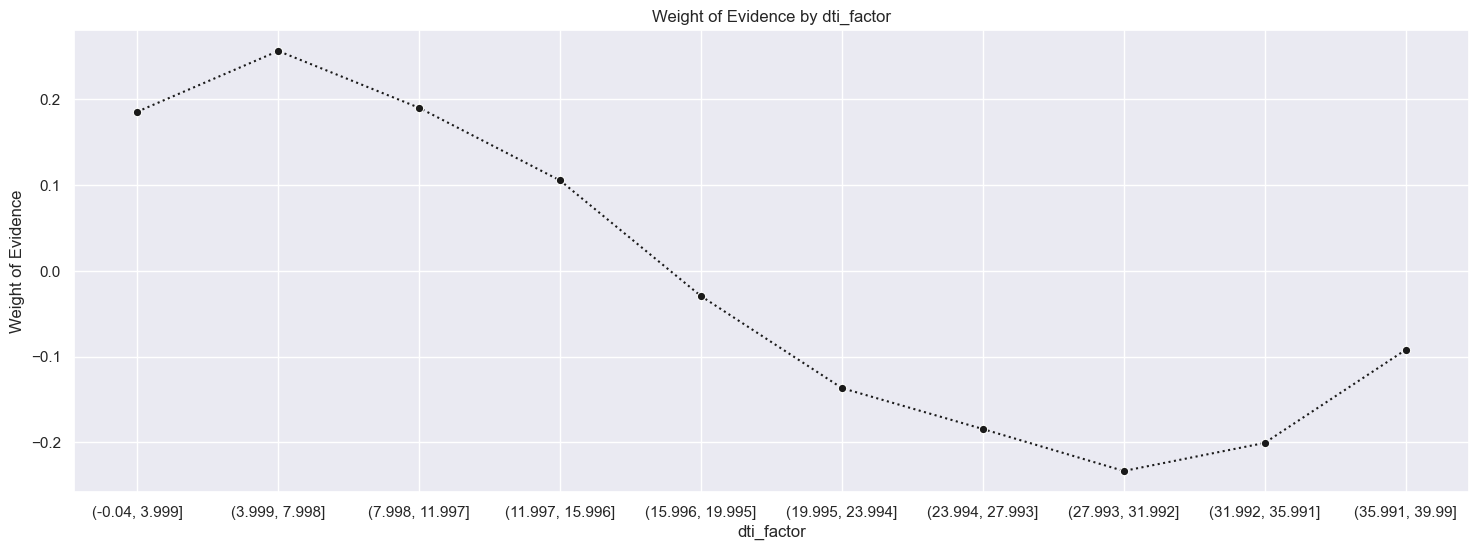

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.04, 3.999]",13362,0.907499,0.035820,12126.0,1236.0,0.036496,0.030313,0.185616,NaN,NaN,0.025864
1,"(3.999, 7.998]",34292,0.913274,0.091929,31318.0,2974.0,0.094259,0.072939,0.256430,0.005775,0.070814,0.025864
2,"(7.998, 11.997]",55478,0.907873,0.148723,50367.0,5111.0,0.151592,0.125349,0.190086,0.005401,0.066344,0.025864
3,"(11.997, 15.996]",68246,0.900536,0.182951,61458.0,6788.0,0.184973,0.166479,0.105343,0.007337,0.084743,0.025864
4,"(15.996, 19.995]",67363,0.887787,0.180584,59804.0,7559.0,0.179995,0.185388,-0.029521,0.012749,0.134864,0.025864
5,"(19.995, 23.994]",56771,0.876645,0.152190,49768.0,7003.0,0.149789,0.171752,-0.136822,0.011142,0.107300,0.025864
6,"(23.994, 27.993]",40198,0.871387,0.107761,35028.0,5170.0,0.105425,0.126796,-0.184580,0.005258,0.047759,0.025864
7,"(27.993, 31.992]",24173,0.865801,0.064802,20929.0,3244.0,0.062991,0.079561,-0.233526,0.005586,0.048946,0.025864
8,"(31.992, 35.991]",10970,0.869553,0.029408,9539.0,1431.0,0.028710,0.035096,-0.200840,0.003753,0.032687,0.025864
9,"(35.991, 39.99]",2175,0.881379,0.005831,1917.0,258.0,0.005770,0.006328,-0.092298,0.011826,0.108542,0.025864


In [67]:
# Convert numerical features with high cardinality into bins.
X_train['dti_factor'] = pd.cut(X_train['dti'], 10)
woe_ordered_continuous(X_train,'dti_factor', y_train)

#### ANNUAL_INC
The self-reported annual income provided by the borrower during registration.

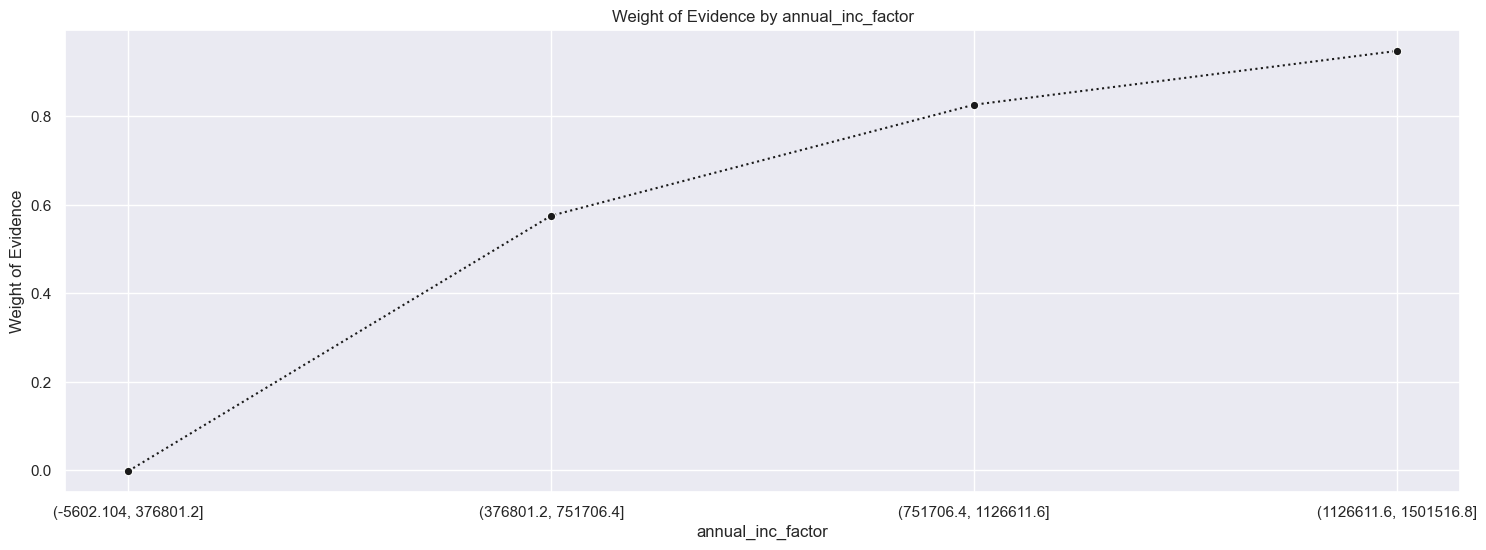

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-5602.104, 376801.2]",372118,0.890578,0.997561,331400.0,40718.0,0.997430,0.998627,-0.001199,NaN,NaN,inf
1,"(376801.2, 751706.4]",774,0.935401,0.002075,724.0,50.0,0.002179,0.001226,0.574913,0.044823,0.576113,inf
2,"(751706.4, 1126611.6]",98,0.948980,0.000263,93.0,5.0,0.000280,0.000123,0.825306,0.013579,0.250393,inf
3,"(1126611.6, 1501516.8]",22,0.954545,0.000059,21.0,1.0,0.000063,0.000025,0.946667,0.005566,0.121361,inf
4,"(1501516.8, 1876422.0]",2,1.000000,0.000005,2.0,0.0,0.000006,0.000000,inf,0.045455,inf,inf
5,"(1876422.0, 2251327.2]",6,1.000000,0.000016,6.0,0.0,0.000018,0.000000,inf,0.000000,NaN,inf
6,"(2251327.2, 2626232.4]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
7,"(2626232.4, 3001137.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(3001137.6, 3376042.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(3376042.8, 3750948.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [68]:
# Convert numerical features with high cardinality into bins.
X_train['annual_inc_factor'] = pd.cut(X_train['annual_inc'], 20)
woe_ordered_continuous(X_train,'annual_inc_factor', y_train)

<b>Problem:</b> <code>annual_inc</code> column have extreme values.

<b>Solution:</b> Replace the values with median.

In [69]:
median = X_train.loc[X_train['annual_inc'] < 751706, 'annual_inc'].median()
X_train['annual_inc'] = np.where(X_train['annual_inc'] > 751706, median, X_train['annual_inc'])

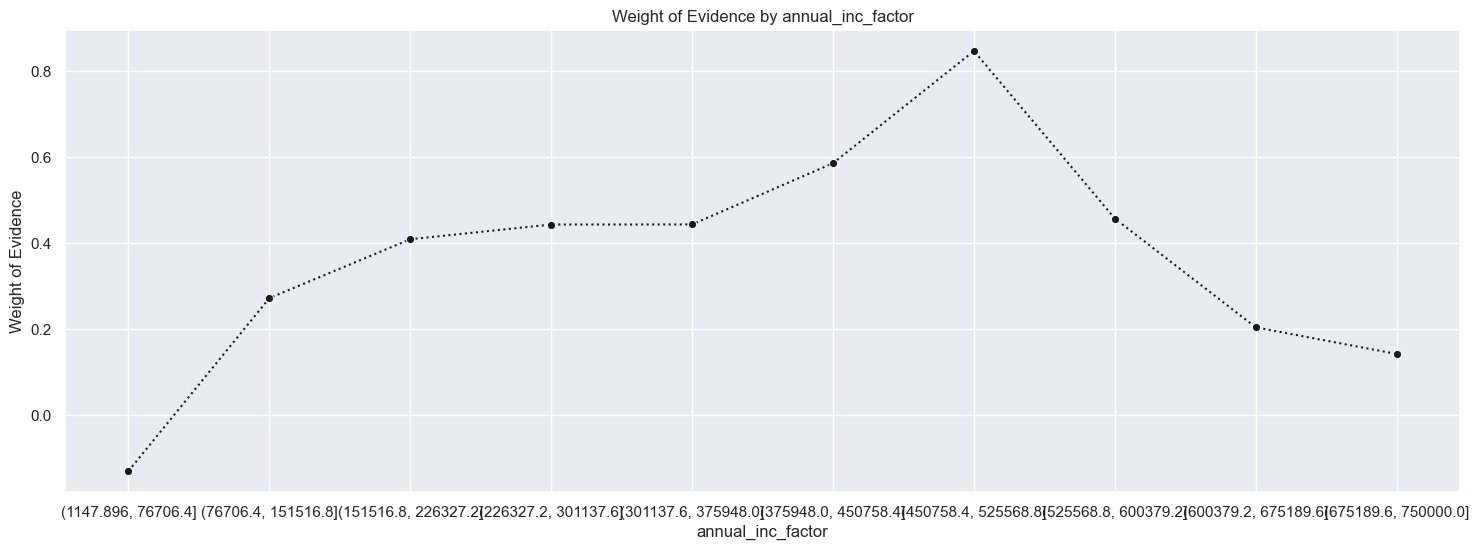

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(1147.896, 76706.4]",245067,0.877503,0.656967,215047.0,30020.0,0.647237,0.736253,-0.128862,NaN,NaN,0.038212
1,"(76706.4, 151516.8]",111692,0.914551,0.299420,102148.0,9544.0,0.307439,0.234071,0.272655,0.037048,0.401517,0.038212
2,"(151516.8, 226327.2]",11957,0.924647,0.032054,11056.0,901.0,0.033276,0.022097,0.409368,0.010096,0.136713,0.038212
3,"(226327.2, 301137.6]",2849,0.926992,0.007637,2641.0,208.0,0.007949,0.005101,0.443520,0.002345,0.034152,0.038212
4,"(301137.6, 375948.0]",685,0.927007,0.001836,635.0,50.0,0.001911,0.001226,0.443747,0.000015,0.000227,0.038212
5,"(375948.0, 450758.4]",391,0.936061,0.001048,366.0,25.0,0.001102,0.000613,0.585902,0.009054,0.142156,0.038212
6,"(450758.4, 525568.8]",180,0.950000,0.000483,171.0,9.0,0.000515,0.000221,0.846584,0.013939,0.260681,0.038212
7,"(525568.8, 600379.2]",111,0.927928,0.000298,103.0,8.0,0.000310,0.000196,0.457432,0.022072,0.389152,0.038212
8,"(600379.2, 675189.6]",44,0.909091,0.000118,40.0,4.0,0.000120,0.000098,0.204730,0.018837,0.252702,0.038212
9,"(675189.6, 750000.0]",52,0.903846,0.000139,47.0,5.0,0.000141,0.000123,0.142855,0.005245,0.061875,0.038212


In [70]:
X_train['annual_inc_factor'] = pd.cut(X_train['annual_inc'], 10)
woe_ordered_continuous(X_train,'annual_inc_factor', y_train)

#### REVOL_BAL
Total credit revolving balance.

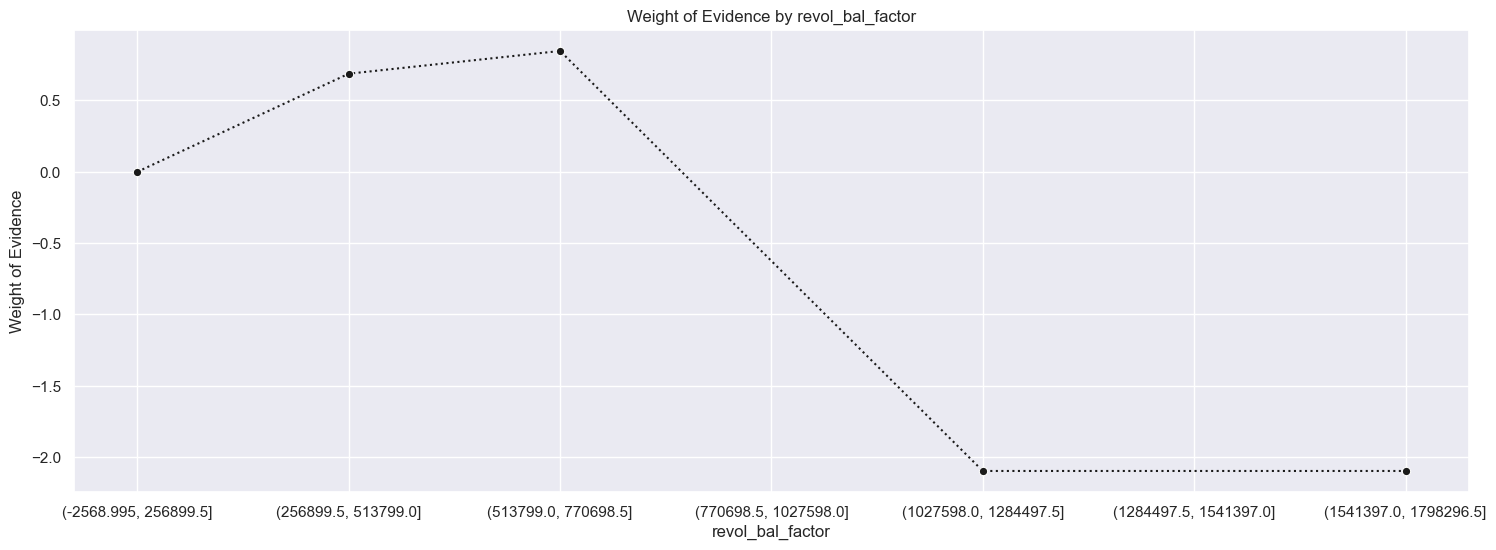

,revol_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-2568.995, 256899.5]",372738,0.890658,0.999223,331982.0,40756.0,0.999181,0.999559,-0.000377,NaN,NaN,inf
1,"(256899.5, 513799.0]",258,0.941860,0.000692,243.0,15.0,0.000731,0.000368,0.687156,0.051203,0.687534,inf
2,"(513799.0, 770698.5]",20,0.950000,0.000054,19.0,1.0,0.000057,0.000025,0.846584,0.008140,0.159428,inf
3,"(770698.5, 1027598.0]",5,1.000000,0.000013,5.0,0.0,0.000015,0.000000,inf,0.050000,inf,inf
4,"(1027598.0, 1284497.5]",2,0.500000,0.000005,1.0,1.0,0.000003,0.000025,-2.097855,0.500000,inf,inf
5,"(1284497.5, 1541397.0]",1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.500000,inf,inf
6,"(1541397.0, 1798296.5]",2,0.500000,0.000005,1.0,1.0,0.000003,0.000025,-2.097855,0.500000,inf,inf
7,"(1798296.5, 2055196.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(2055196.0, 2312095.5]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(2312095.5, 2568995.0]",2,1.000000,0.000005,2.0,0.0,0.000006,0.000000,inf,NaN,NaN,inf


In [71]:
# Convert numerical features with high cardinality into bins.
X_train['revol_bal_factor'] = pd.cut(X_train['revol_bal'], 10)
woe_ordered_continuous(X_train,'revol_bal_factor', y_train)

<b>Problem:</b> <code>revol_bal</code> column have many extreme values.

<b>Solution:</b> Calculate the upper limit and replace the values with median.

In [72]:
def upper_limit(df):
    Q1 = np.percentile(df,25, axis=0)
    Q3 = np.percentile(df,75, axis=0)
    IQR = Q3 - Q1
    return Q3 + (1.5*IQR)
    
upper_limit(X_train['revol_bal'])

41231.0

In [73]:
median = X_train.loc[X_train['revol_bal'] < 41231, 'revol_bal'].median()
X_train['revol_bal'] = np.where(X_train['revol_bal'] > 41231, median, X_train['revol_bal'])

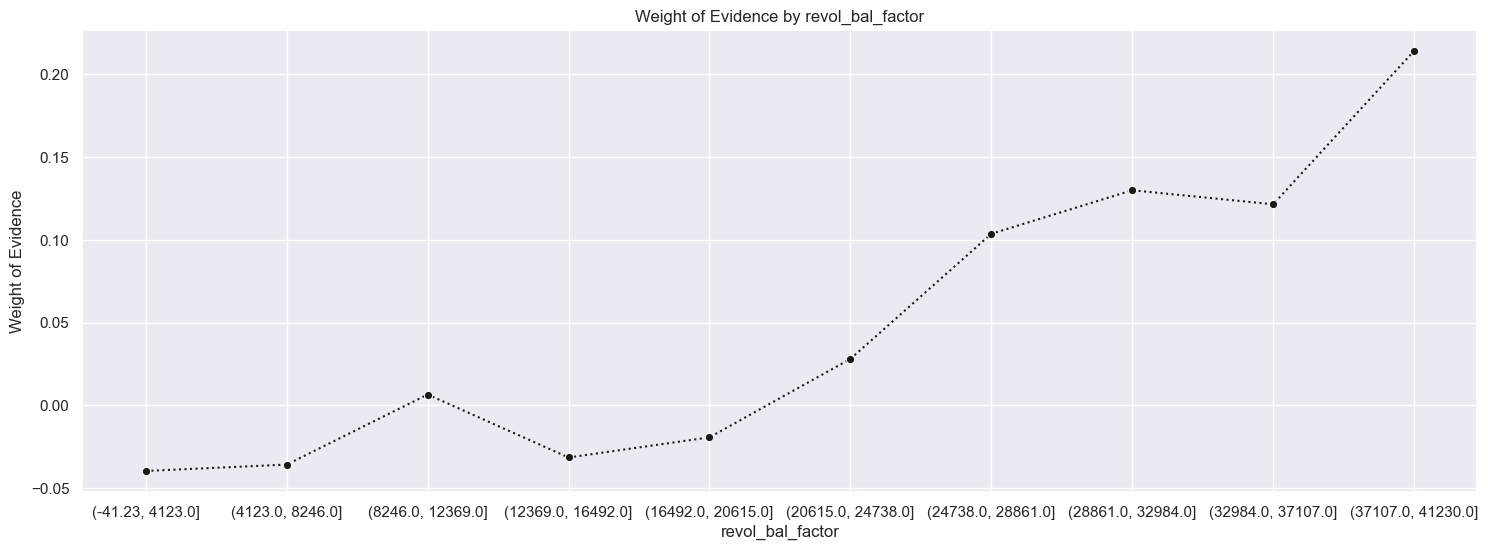

,revol_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-41.23, 4123.0]",50110,0.886789,0.134333,44437.0,5673.0,0.133744,0.139133,-0.039501,NaN,NaN,0.002891
1,"(4123.0, 8246.0]",77687,0.887175,0.208261,68922.0,8765.0,0.207438,0.214965,-0.035646,0.000386,0.003855,0.002891
2,"(8246.0, 12369.0]",85869,0.891334,0.230195,76538.0,9331.0,0.230360,0.228847,0.006590,0.004159,0.042236,0.002891
3,"(12369.0, 16492.0]",50437,0.887602,0.135210,44768.0,5669.0,0.134740,0.139035,-0.031374,0.003732,0.037964,0.002891
4,"(16492.0, 20615.0]",36046,0.888809,0.096631,32038.0,4008.0,0.096426,0.098298,-0.019225,0.001206,0.012149,0.002891
5,"(20615.0, 24738.0]",25168,0.893396,0.067469,22485.0,2683.0,0.067674,0.065802,0.028058,0.004588,0.047283,0.002891
6,"(24738.0, 28861.0]",18468,0.900368,0.049508,16628.0,1840.0,0.050046,0.045127,0.103467,0.006972,0.075410,0.002891
7,"(28861.0, 32984.0]",13186,0.902700,0.035349,11903.0,1283.0,0.035825,0.031466,0.129734,0.002332,0.026267,0.002891
8,"(32984.0, 37107.0]",9414,0.901955,0.025237,8491.0,923.0,0.025556,0.022637,0.121278,0.000745,0.008457,0.002891
9,"(37107.0, 41230.0]",6643,0.909830,0.017808,6044.0,599.0,0.018191,0.014691,0.213705,0.007875,0.092427,0.002891


In [74]:
X_train['revol_bal_factor'] = pd.cut(X_train['revol_bal'], 10)
woe_ordered_continuous(X_train,'revol_bal_factor', y_train)

<b>Problem:</b> <code>revol_bal</code> column have a low IV value.

<b>Solution:</b> Drop the <code>revol_bal</code> column.

#### OUT_PRNCP
Remaining outstanding principal for total amount funded.

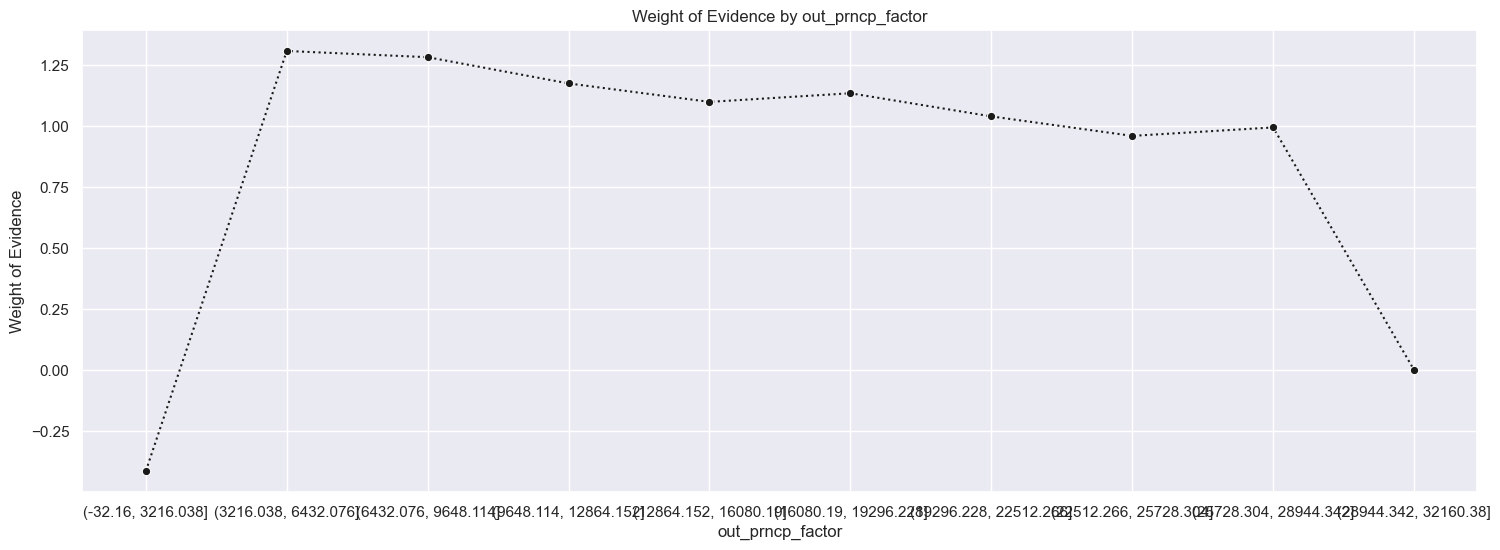

,out_prncp_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-32.16, 3216.038]",227302,0.843631,0.609343,191759.0,35543.0,0.577146,0.871707,-0.412359,NaN,NaN,0.479433
1,"(3216.038, 6432.076]",43193,0.967911,0.115790,41807.0,1386.0,0.125828,0.033992,1.308787,0.124281,1.721146,0.479433
2,"(6432.076, 9648.114]",32593,0.967110,0.087374,31521.0,1072.0,0.094870,0.026291,1.283273,0.000802,0.025514,0.479433
3,"(9648.114, 12864.152]",25817,0.963512,0.069209,24875.0,942.0,0.074867,0.023103,1.175758,0.003597,0.107515,0.479433
4,"(12864.152, 16080.19]",16717,0.960759,0.044814,16061.0,656.0,0.048340,0.016089,1.100133,0.002754,0.075625,0.479433
5,"(16080.19, 19296.228]",11495,0.962070,0.030815,11059.0,436.0,0.033285,0.010693,1.135502,0.001312,0.035369,0.479433
6,"(19296.228, 22512.266]",7654,0.958453,0.020519,7336.0,318.0,0.022079,0.007799,1.040643,0.003617,0.094860,0.479433
7,"(22512.266, 25728.304]",4616,0.955156,0.012374,4409.0,207.0,0.013270,0.005077,0.960829,0.003297,0.079813,0.479433
8,"(25728.304, 28944.342]",2789,0.956615,0.007477,2668.0,121.0,0.008030,0.002968,0.995439,0.001459,0.034609,0.479433
9,"(28944.342, 32160.38]",852,0.890845,0.002284,759.0,93.0,0.002284,0.002281,0.001547,0.065770,0.993892,0.479433


In [75]:
# Convert numerical features with high cardinality into bins.
X_train['out_prncp_factor'] = pd.cut(X_train['out_prncp'], 10)
woe_ordered_continuous(X_train,'out_prncp_factor', y_train)

#### LAST_PYMNT_AMNT
Last total payment amount received.

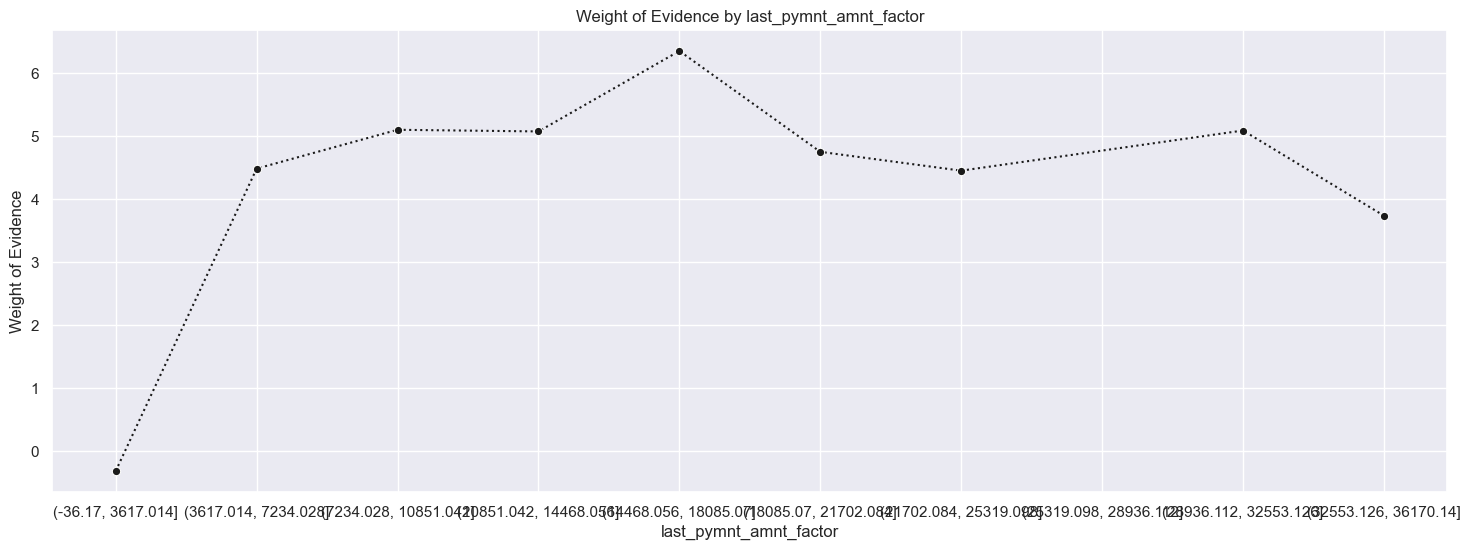

,last_pymnt_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-36.17, 3617.014]",283939,0.856702,0.761173,243251.0,40688.0,0.732124,0.997891,-0.309694,NaN,NaN,inf
1,"(3617.014, 7234.028]",31007,0.998613,0.083122,30964.0,43.0,0.093194,0.001055,4.481525,0.141912,4.791220,inf
2,"(7234.028, 10851.042]",21333,0.999250,0.057189,21317.0,16.0,0.064159,0.000392,5.096816,0.000637,0.615291,inf
3,"(10851.042, 14468.056]",14288,0.999230,0.038303,14277.0,11.0,0.042970,0.000270,5.070655,0.000020,0.026162,inf
4,"(14468.056, 18085.07]",9292,0.999785,0.024910,9290.0,2.0,0.027961,0.000049,6.345692,0.000555,1.275037,inf
5,"(18085.07, 21702.084]",5643,0.998937,0.015128,5637.0,6.0,0.016966,0.000147,4.747493,0.000848,1.598199,inf
6,"(21702.084, 25319.098]",3490,0.998567,0.009356,3485.0,5.0,0.010489,0.000123,4.448930,0.000369,0.298562,inf
7,"(25319.098, 28936.112]",2033,1.000000,0.005450,2033.0,0.0,0.006119,0.000000,inf,0.001433,inf,inf
8,"(28936.112, 32553.126]",1318,0.999241,0.003533,1317.0,1.0,0.003964,0.000025,5.085257,0.000759,inf,inf
9,"(32553.126, 36170.14]",685,0.997080,0.001836,683.0,2.0,0.002056,0.000049,3.735493,0.002161,1.349764,inf


In [76]:
# Convert numerical features with high cardinality into bins.
X_train['last_pymnt_amnt_factor'] = pd.cut(X_train['last_pymnt_amnt'], 10)
woe_ordered_continuous(X_train,'last_pymnt_amnt_factor', y_train)

<b>Problem:</b> <code>last_pymnt_amount</code> column have many extreme values.

<b>Solution:</b> Calculate the upper limit and replace the values with median.

In [77]:
upper_limit(X_train['last_pymnt_amnt'])

7480.756249999999

In [78]:
median = X_train.loc[X_train['last_pymnt_amnt'] < 7481, 'last_pymnt_amnt'].median()
X_train['last_pymnt_amnt'] = np.where(X_train['last_pymnt_amnt'] > 7481, median, X_train['last_pymnt_amnt'])

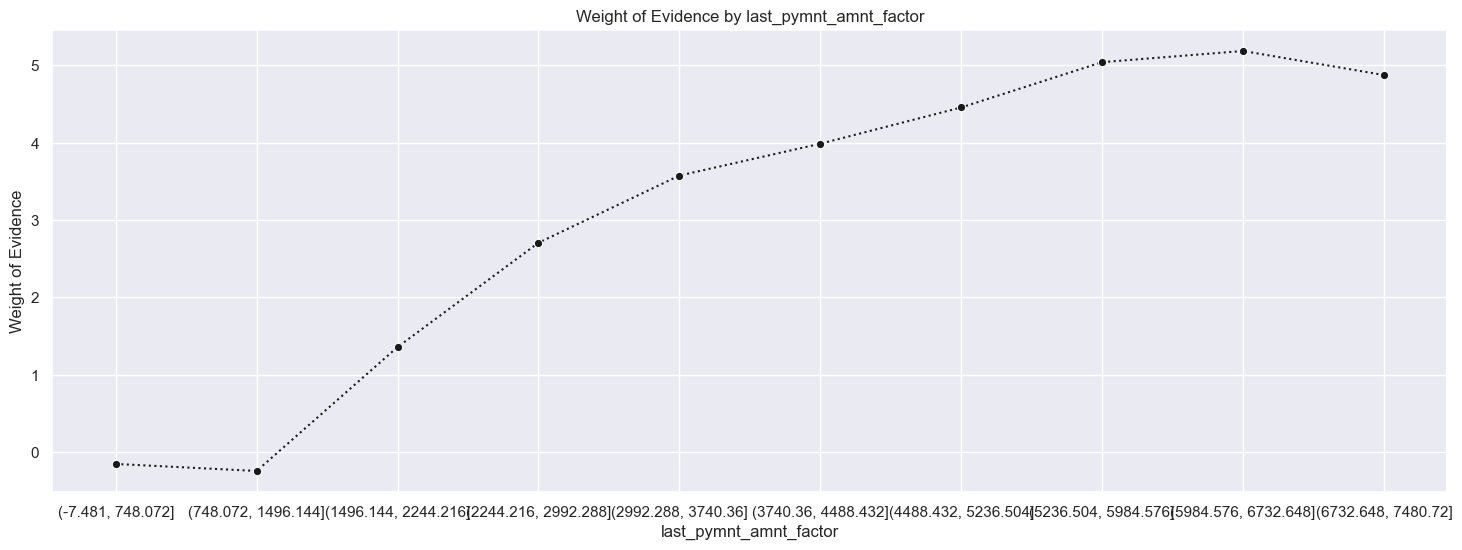

,last_pymnt_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-7.481, 748.072]",284711,0.874849,0.763243,249079.0,35632.0,0.749664,0.873890,-0.153329,NaN,NaN,0.61201
1,"(748.072, 1496.144]",35446,0.864583,0.095022,30646.0,4800.0,0.092237,0.117722,-0.243969,0.010266,0.090640,0.61201
2,"(1496.144, 2244.216]",7190,0.969402,0.019275,6970.0,220.0,0.020978,0.005396,1.357888,0.104819,1.601857,0.61201
3,"(2244.216, 2992.288]",7134,0.991870,0.019125,7076.0,58.0,0.021297,0.001422,2.706166,0.022468,1.348278,0.61201
4,"(2992.288, 3740.36]",7006,0.996574,0.018781,6982.0,24.0,0.021014,0.000589,3.575182,0.004704,0.869016,0.61201
5,"(3740.36, 4488.432]",7039,0.997727,0.018870,7023.0,16.0,0.021137,0.000392,3.986502,0.001153,0.411320,0.61201
6,"(4488.432, 5236.504]",7026,0.998577,0.018835,7016.0,10.0,0.021116,0.000245,4.455508,0.000850,0.469006,0.61201
7,"(5236.504, 5984.576]",6306,0.999207,0.016905,6301.0,5.0,0.018964,0.000123,5.041171,0.000630,0.585662,0.61201
8,"(5984.576, 6732.648]",5830,0.999314,0.015629,5826.0,4.0,0.017535,0.000098,5.185936,0.000107,0.144766,0.61201
9,"(6732.648, 7480.72]",5340,0.999064,0.014315,5335.0,5.0,0.016057,0.000123,4.874751,0.000250,0.311185,0.61201


In [79]:
X_train['last_pymnt_amnt_factor'] = pd.cut(X_train['last_pymnt_amnt'], 10)
woe_ordered_continuous(X_train,'last_pymnt_amnt_factor', y_train)

<b>Problem:</b> <code>last_pymnt_amnt</code> column have a very high IV value.

<b>Solution:</b> Drop the <code>last_pymnt_amnt</code> column.

#### TOT_CUR_BAL
Total current balance of all accounts.

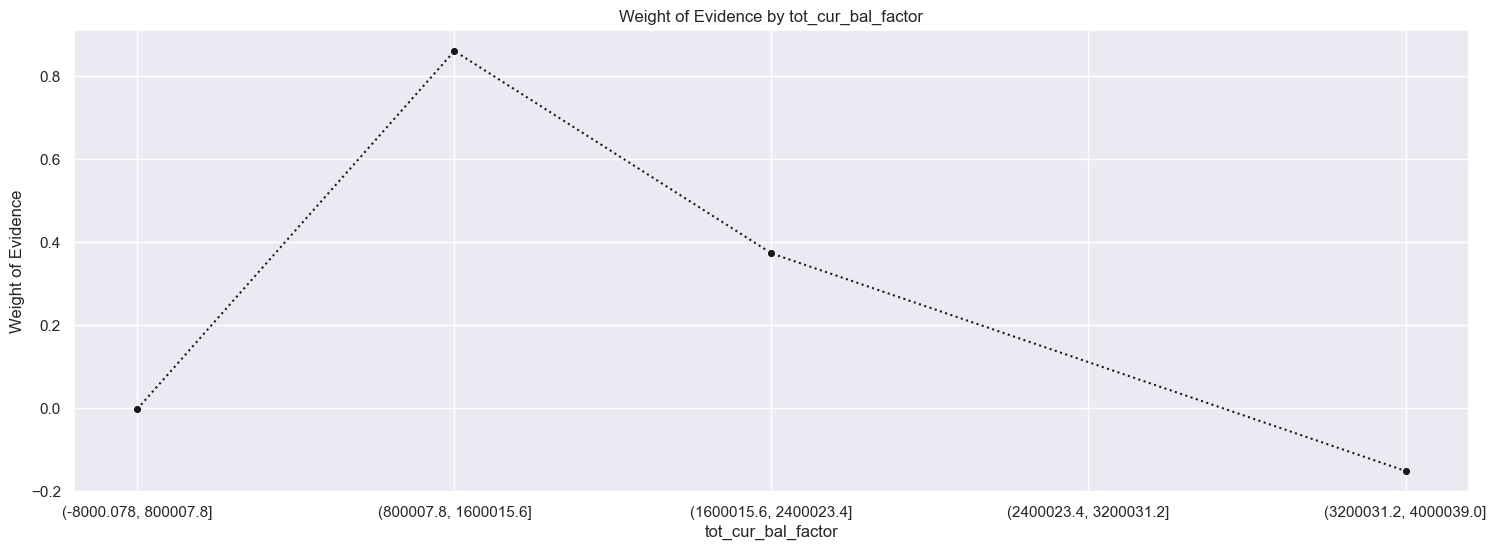

,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-8000.078, 800007.8]",371632,0.890475,0.996258,330929.0,40703.0,0.996012,0.998259,-0.002253,NaN,NaN,inf
1,"(800007.8, 1600015.6]",1298,0.950693,0.003480,1234.0,64.0,0.003714,0.001570,0.861278,0.060218,0.863531,inf
2,"(1600015.6, 2400023.4]",77,0.922078,0.000206,71.0,6.0,0.000214,0.000147,0.373065,0.028615,0.488213,inf
3,"(2400023.4, 3200031.2]",10,1.000000,0.000027,10.0,0.0,0.000030,0.000000,inf,0.077922,inf,inf
4,"(3200031.2, 4000039.0]",8,0.875000,0.000021,7.0,1.0,0.000021,0.000025,-0.151945,0.125000,inf,inf
5,"(4000039.0, 4800046.8]",2,1.000000,0.000005,2.0,0.0,0.000006,0.000000,inf,0.125000,inf,inf
6,"(4800046.8, 5600054.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
7,"(5600054.6, 6400062.4]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(6400062.4, 7200070.2]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(7200070.2, 8000078.0]",1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,NaN,NaN,inf


In [80]:
# Convert numerical features with high cardinality into bins.
X_train['tot_cur_bal_factor'] = pd.cut(X_train['tot_cur_bal'], 10)
woe_ordered_continuous(X_train,'tot_cur_bal_factor', y_train)

<b>Problem:</b> <code>annual_inc</code> column have many extreme values.

<b>Solution:</b> Calculate the upper limit and replace the values with median.

In [81]:
X_train['tot_cur_bal'] = X_train['tot_cur_bal'].fillna(X_train['tot_cur_bal'].median())

In [82]:
upper_limit(X_train['tot_cur_bal'])

412439.125

In [83]:
median = X_train.loc[X_train['tot_cur_bal'] < 412439, 'tot_cur_bal'].median()
X_train['tot_cur_bal'] = np.where(X_train['tot_cur_bal'] > 412439, median, X_train['tot_cur_bal'])

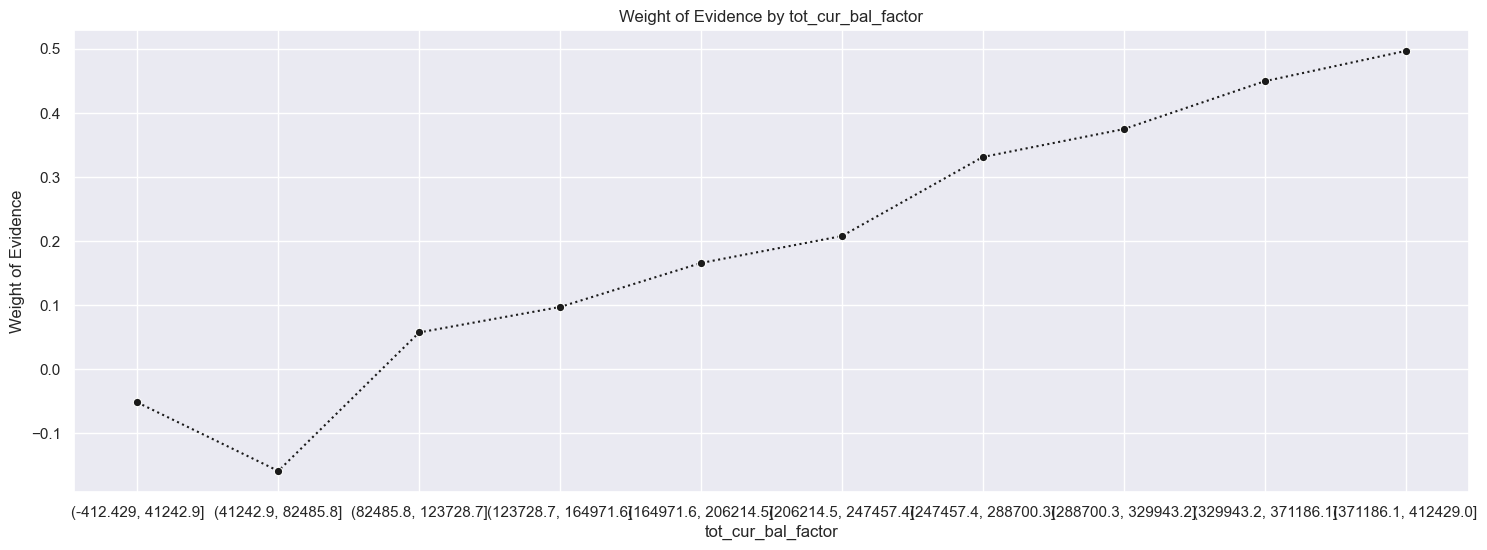

,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-412.429, 41242.9]",111015,0.885538,0.297605,98308.0,12707.0,0.295882,0.311645,-0.051903,NaN,NaN,0.02991
1,"(41242.9, 82485.8]",120904,0.874247,0.324115,105700.0,15204.0,0.318130,0.372885,-0.158809,0.011291,0.106906,0.02991
2,"(82485.8, 123728.7]",25525,0.896141,0.068426,22874.0,2651.0,0.068845,0.065017,0.057209,0.021894,0.216018,0.02991
3,"(123728.7, 164971.6]",26093,0.899782,0.069949,23478.0,2615.0,0.070663,0.064134,0.096945,0.003641,0.039736,0.02991
4,"(164971.6, 206214.5]",25467,0.905800,0.068271,23068.0,2399.0,0.069429,0.058837,0.165539,0.006018,0.068595,0.02991
5,"(206214.5, 247457.4]",20579,0.909325,0.055167,18713.0,1866.0,0.056321,0.045764,0.207566,0.003525,0.042027,0.02991
6,"(247457.4, 288700.3]",15961,0.918990,0.042788,14668.0,1293.0,0.044147,0.031711,0.330848,0.009665,0.123282,0.02991
7,"(288700.3, 329943.2]",12116,0.922169,0.032480,11173.0,943.0,0.033628,0.023127,0.374334,0.003179,0.043486,0.02991
8,"(329943.2, 371186.1]",8852,0.927361,0.023730,8209.0,643.0,0.024707,0.015770,0.448987,0.005192,0.074653,0.02991
9,"(371186.1, 412429.0]",6516,0.930479,0.017468,6063.0,453.0,0.018248,0.011110,0.496213,0.003118,0.047226,0.02991


In [84]:
X_train['tot_cur_bal_factor'] = pd.cut(X_train['tot_cur_bal'], 10)
woe_ordered_continuous(X_train,'tot_cur_bal_factor', y_train)

#### TOTAL_REC_INT
Interest received to date.

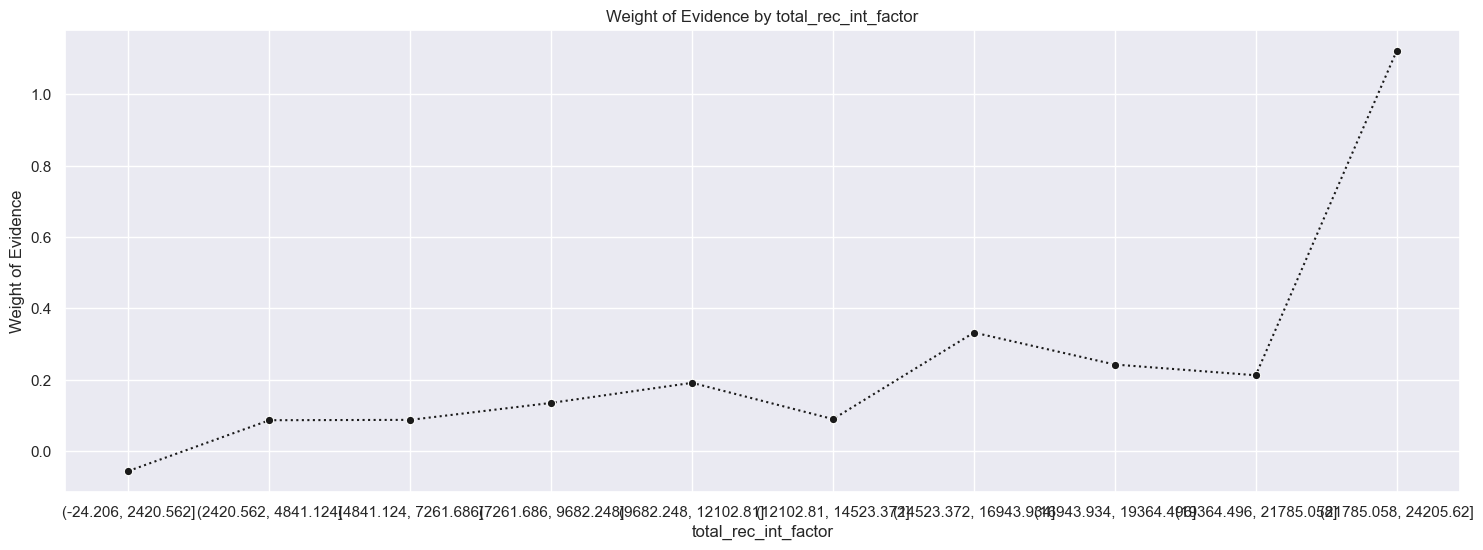

,total_rec_int_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-24.206, 2420.562]",233651,0.885226,0.626363,206834.0,26817.0,0.622518,0.657699,-0.054975,NaN,NaN,0.005784
1,"(2420.562, 4841.124]",88134,0.898893,0.236266,79223.0,8911.0,0.238441,0.218546,0.087125,0.013666,0.142100,0.005784
2,"(4841.124, 7261.686]",29876,0.898982,0.080091,26858.0,3018.0,0.080836,0.074018,0.088114,0.000090,0.000989,0.005784
3,"(7261.686, 9682.248]",12502,0.903215,0.033515,11292.0,1210.0,0.033986,0.029676,0.135619,0.004233,0.047505,0.005784
4,"(9682.248, 12102.81]",5088,0.908019,0.013640,4620.0,468.0,0.013905,0.011478,0.191827,0.004803,0.056208,0.005784
5,"(12102.81, 14523.372]",2063,0.899176,0.005530,1855.0,208.0,0.005583,0.005101,0.090247,0.008843,0.101580,0.005784
6,"(14523.372, 16943.934]",1088,0.919118,0.002917,1000.0,88.0,0.003010,0.002158,0.332563,0.019942,0.242317,0.005784
7,"(16943.934, 19364.496]",467,0.912206,0.001252,426.0,41.0,0.001282,0.001006,0.243012,0.006912,0.089551,0.005784
8,"(19364.496, 21785.058]",133,0.909774,0.000357,121.0,12.0,0.000364,0.000294,0.213029,0.002431,0.029983,0.005784
9,"(21785.058, 24205.62]",26,0.961538,0.000070,25.0,1.0,0.000075,0.000025,1.121021,0.051764,0.907992,0.005784


In [85]:
# Convert numerical features with high cardinality into bins.
X_train['total_rec_int_factor'] = pd.cut(X_train['total_rec_int'], 10)
woe_ordered_continuous(X_train,'total_rec_int_factor', y_train)

<b>Problem:</b> <code>total_rec_int</code> column have a low IV value.

<b>Solution:</b> Drop the <code>total_rec_int</code> column.

In [86]:
# Drop the previous bin columns
dropped_cols = ['total_rec_int','last_pymnt_amnt','revol_bal', 'loan_amnt', 'mths_since_earliest_cr_line', 'total_acc',
                'inq_last_6mths','emp_length']

for col in dropped_cols:
    selected_num_cols.remove(col)
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)

bin_cols = ['total_rec_int_factor','tot_cur_bal_factor','last_pymnt_amnt_factor','out_prncp_factor','revol_bal_factor',
            'annual_inc_factor','dti_factor','loan_amnt_factor','revol_util_factor','mths_since_earliest_cr_line_factor',
            'int_rate_factor','total_acc_factor','inq_last_6mths_factor']
X_train = X_train.drop(columns=bin_cols)

### 6.3.2. One-Hot Encoding

In [87]:
# Apply one-hot encoding to categorical features
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

X_train = dummy_creation(X_train, selected_cat_cols)
X_test = dummy_creation(X_test, selected_cat_cols)
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

## 7. Exploratory Data Analysis

### 7.1. Categorical Features

In [88]:
X_train[selected_cat_cols].describe().transpose()

,count,unique,top,freq
initial_list_status,373028,2,f,242325
verification_status,373028,3,Verified,134571
home_ownership,373028,5,MORTGAGE,188739
grade,373028,7,B,109344
purpose,373028,14,debt_consolidation,219196


There are five categorical features.

<AxesSubplot:xlabel='initial_list_status', ylabel='count'>

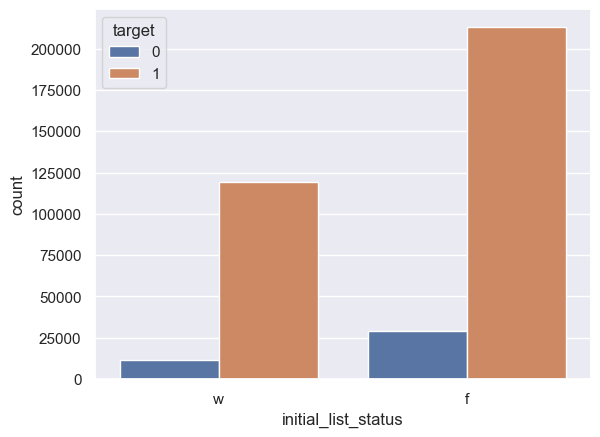

In [89]:
sns.countplot(x="initial_list_status", hue=y_train, data=X_train)

<AxesSubplot:xlabel='verification_status', ylabel='count'>

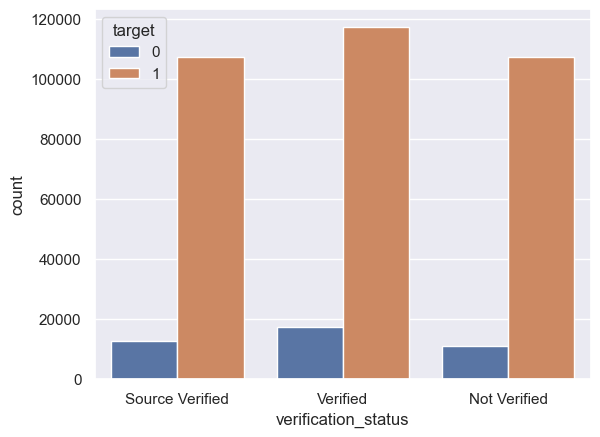

In [90]:
sns.countplot(x="verification_status", hue=y_train, data=X_train)

<AxesSubplot:xlabel='home_ownership', ylabel='count'>

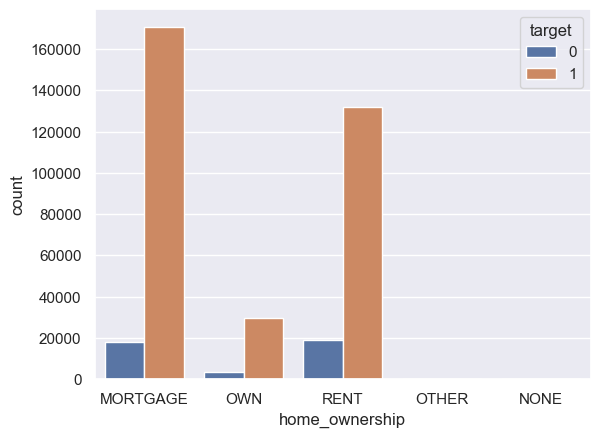

In [91]:
sns.countplot(x="home_ownership", hue=y_train, data=X_train)

In [92]:
X_train['home_ownership'].value_counts()

MORTGAGE    188739
RENT        150776
OWN          33313
OTHER          159
NONE            41
Name: home_ownership, dtype: int64

<b>Note:</b> OTHER and NONE, relatively, have small number of frequencies.

<AxesSubplot:xlabel='grade', ylabel='count'>

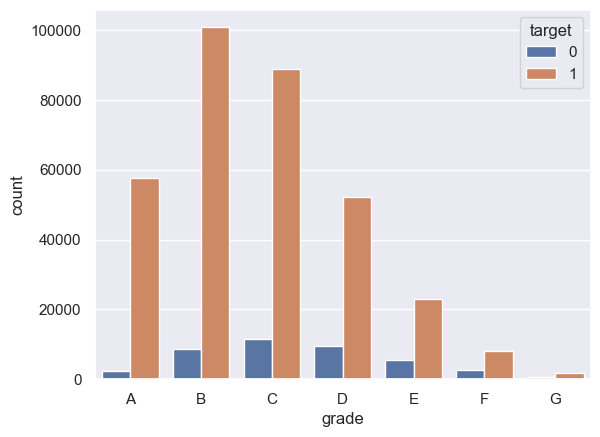

In [93]:
sns.countplot(x="grade", hue=y_train, data=X_train, order=['A','B','C','D','E','F','G'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'credit_card'),
  Text(1, 0, 'other'),
  Text(2, 0, 'debt_consolidation'),
  Text(3, 0, 'car'),
  Text(4, 0, 'home_improvement'),
  Text(5, 0, 'small_business'),
  Text(6, 0, 'major_purchase'),
  Text(7, 0, 'house'),
  Text(8, 0, 'medical'),
  Text(9, 0, 'vacation'),
  Text(10, 0, 'wedding'),
  Text(11, 0, 'moving'),
  Text(12, 0, 'educational'),
  Text(13, 0, 'renewable_energy')])

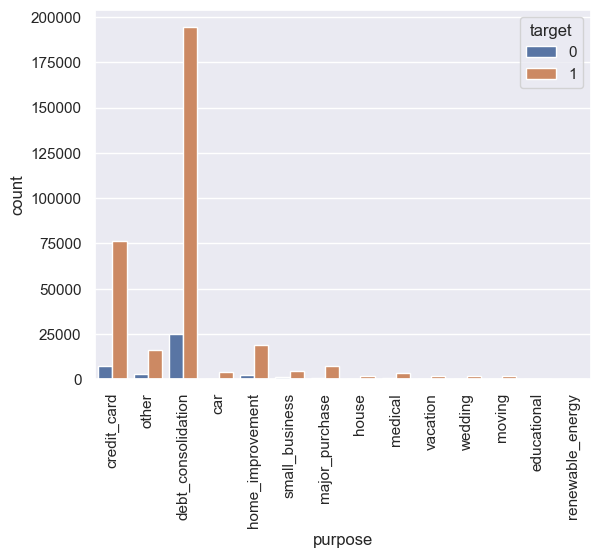

In [94]:
sns.countplot(x="purpose", hue=y_train, data=X_train)
plt.xticks(rotation=90)

<b>Note:</b> debt_consolidation have relatively large frequencies.

In [95]:
X_train[selected_num_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
int_rate,373028.0,13.833770,4.354663,5.42,10.99,13.66,16.49,26.06
out_prncp,373028.0,4409.242313,6357.128699,0.00,0.00,443.97,7332.75,32160.38
term,373028.0,42.615847,10.724327,36.00,36.00,36.00,60.00,60.00
tot_cur_bal,373028.0,108603.077174,96028.886224,0.00,33659.75,81844.50,159212.00,412429.00
revol_util,373028.0,56.183464,23.668325,0.00,39.30,57.60,74.70,114.90
dti,373028.0,17.222219,7.850161,0.00,11.37,16.87,22.79,39.99
annual_inc,373028.0,72880.572612,44944.385346,1896.00,45000.00,63000.00,89000.00,750000.00


There are seven numerical features.

<AxesSubplot:xlabel='grade', ylabel='int_rate'>

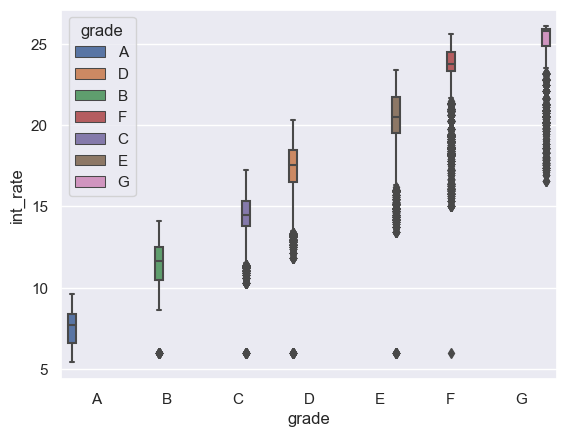

In [96]:
sns.boxplot(data=X_train, x="grade", y="int_rate", hue="grade", order=['A','B','C','D','E','F','G'])

<b>Note:</b> There is a trend where the higher grade loan will have the higher interest rate. 

<AxesSubplot:xlabel='grade', ylabel='out_prncp'>

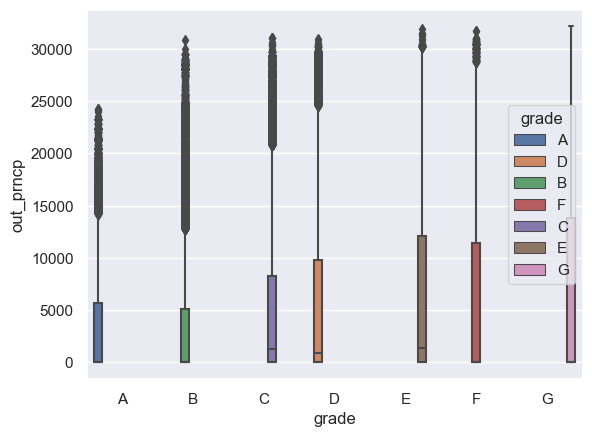

In [97]:
sns.boxplot(data=X_train, x="grade", y="out_prncp", hue="grade", order=['A','B','C','D','E','F','G'])

<AxesSubplot:xlabel='term', ylabel='count'>

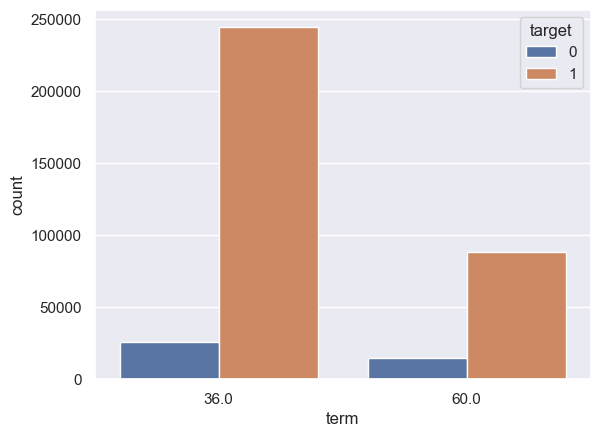

In [98]:
sns.countplot(x="term", hue=y_train, data=X_train)

<AxesSubplot:xlabel='grade', ylabel='tot_cur_bal'>

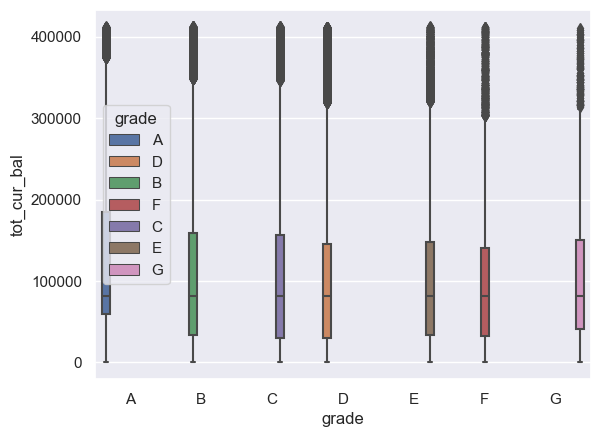

In [99]:
sns.boxplot(data=X_train, x="grade", y="tot_cur_bal", hue="grade", order=['A','B','C','D','E','F','G'])

<AxesSubplot:xlabel='grade', ylabel='revol_util'>

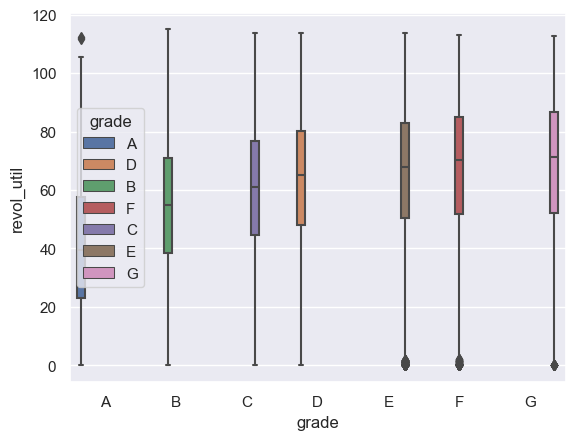

In [100]:
sns.boxplot(data=X_train, x="grade", y="revol_util", hue="grade", order=['A','B','C','D','E','F','G'])

<AxesSubplot:xlabel='grade', ylabel='dti'>

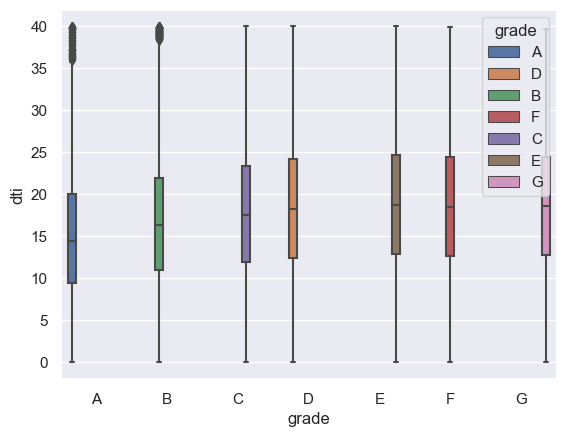

In [101]:
sns.boxplot(data=X_train, x="grade", y="dti", hue="grade", order=['A','B','C','D','E','F','G'])

<AxesSubplot:xlabel='grade', ylabel='annual_inc'>

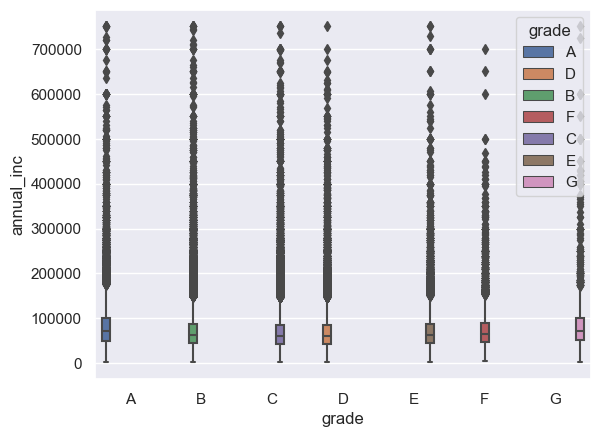

In [102]:
sns.boxplot(data=X_train, x="grade", y="annual_inc", hue="grade", order=['A','B','C','D','E','F','G'])

## 8. Model Building

In [103]:
# Custom transformer class to create new categorical dummy features
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): 
        self.X = X
    def fit(self, X, y = None):
        return self
    def transform(self, X):        
        # Categorical Features
        X_new = X.loc[:, 'initial_list_status:f'].to_frame()
        X_new['initial_list_status:w'] = X.loc[:, 'initial_list_status:w']
        
        X_new['verification_status:Verified'] = X.loc[:, 'verification_status:Verified']
        X_new['verification_status:Source Verified'] = X.loc[:, 'verification_status:Source Verified']
        X_new['verification_status:Not Verified'] = X.loc[:, 'verification_status:Not Verified']
        
        X_new['home_ownership:OTHER'] = X.loc[:, 'home_ownership:OTHER']
        X_new['home_ownership:NONE'] = X.loc[:, 'home_ownership:NONE']
        X_new['home_ownership:RENT'] = X.loc[:, 'home_ownership:RENT']
        X_new['home_ownership:OWN'] = X.loc[:, 'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:, 'home_ownership:MORTGAGE']
        
        X_new['grade:A'] = X.loc[:, 'grade:A']
        X_new['grade:B'] = X.loc[:, 'grade:B']
        X_new['grade:C'] = X.loc[:, 'grade:C']
        X_new['grade:D'] = X.loc[:, 'grade:D']
        X_new['grade:E'] = X.loc[:, 'grade:E']
        X_new['grade:F'] = X.loc[:, 'grade:F']
        X_new['grade:G'] = X.loc[:, 'grade:G']
        
        X_new['purpose:small_business'] = X.loc[:, 'purpose:small_business']
        X_new['purpose:educational'] = X.loc[:, 'purpose:educational']
        X_new['purpose:renewable_energy'] = X.loc[:, 'purpose:renewable_energy']
        X_new['purpose:moving'] = X.loc[:, 'purpose:moving']
        X_new['purpose:house'] = X.loc[:, 'purpose:house']
        X_new['purpose:other'] = X.loc[:, 'purpose:other']
        X_new['purpose:medical'] = X.loc[:, 'purpose:medical']
        X_new['purpose:vacation'] = X.loc[:, 'purpose:vacation']
        X_new['purpose:wedding'] = X.loc[:, 'purpose:wedding']
        X_new['purpose:debt_consolidation'] = X.loc[:, 'purpose:debt_consolidation']
        X_new['purpose:home_improvement'] = X.loc[:, 'purpose:home_improvement']
        X_new['purpose:major_purchase'] = X.loc[:, 'purpose:major_purchase']
        X_new['purpose:car'] = X.loc[:, 'purpose:car']
        X_new['purpose:credit_card'] = X.loc[:, 'purpose:credit_card']
        
        # Numerical features
        X_new['int_rate:Under 7.484'] = np.where((X['int_rate'] < 7.484), 1, 0)
        X_new['int_rate:7.484-9.548'] = np.where((X['int_rate'] > 7.484) & (X['int_rate'] <= 9.548), 1, 0)
        X_new['int_rate:9.548-11.612'] = np.where((X['int_rate'] > 9.548) & (X['int_rate'] <= 11.612), 1, 0)
        X_new['int_rate:11.612-13.676'] = np.where((X['int_rate'] > 11.612) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-17.804'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 17.804), 1, 0)
        X_new['int_rate:17.804-19.868'] = np.where((X['int_rate'] > 17.804) & (X['int_rate'] <= 19.868), 1, 0)
        X_new['int_rate:19.868-21.932'] = np.where((X['int_rate'] > 19.868) & (X['int_rate'] <= 21.932), 1, 0)
        X_new['int_rate:21.932-23.996'] = np.where((X['int_rate'] > 21.932) & (X['int_rate'] <= 23.996), 1, 0)
        X_new['int_rate:Above 23.996'] = np.where((X['int_rate'] > 23.996), 1, 0)
        
        X_new['revol_util:Under 11.49'] = np.where((X['revol_util'] < 11.49), 1, 0)
        X_new['revol_util:11.49-22.98'] = np.where((X['revol_util'] > 11.49) & (X['revol_util'] <= 22.98), 1, 0)
        X_new['revol_util:22.98-34.47'] = np.where((X['revol_util'] > 22.98) & (X['revol_util'] <= 34.47), 1, 0)
        X_new['revol_util:34.47-45.96'] = np.where((X['revol_util'] > 34.47) & (X['revol_util'] <= 45.96), 1, 0)
        X_new['revol_util:45.96-57.45'] = np.where((X['revol_util'] > 45.96) & (X['revol_util'] <= 57.45), 1, 0)
        X_new['revol_util:57.45-68.94'] = np.where((X['revol_util'] > 57.45) & (X['revol_util'] <= 68.94), 1, 0)
        X_new['revol_util:68.94-80.43'] = np.where((X['revol_util'] > 68.94) & (X['revol_util'] <= 80.43), 1, 0)
        X_new['revol_util:80.43-91.92'] = np.where((X['revol_util'] > 80.43) & (X['revol_util'] <= 91.92), 1, 0)
        X_new['revol_util:91.92-103.41'] = np.where((X['revol_util'] > 91.92) & (X['revol_util'] <= 103.41), 1, 0)
        X_new['revol_util:Above 103.41'] = np.where((X['revol_util'] > 103.41), 1, 0)
        
        X_new['dti:Under 3.999'] = np.where((X['dti'] < 3.999), 1, 0)
        X_new['dti:3.999-7.998'] = np.where((X['dti'] > 3.999) & (X['dti'] <= 7.998), 1, 0)
        X_new['dti:7.998-11.997'] = np.where((X['dti'] > 7.998) & (X['dti'] <= 11.997), 1, 0)
        X_new['dti:11.997-15.996'] = np.where((X['dti'] > 11.997) & (X['dti'] <= 15.996), 1, 0)
        X_new['dti:15.996-19.995'] = np.where((X['dti'] > 15.996) & (X['dti'] <= 19.995), 1, 0)
        X_new['dti:19.995-23.994'] = np.where((X['dti'] > 19.995) & (X['dti'] <= 23.994), 1, 0)
        X_new['dti:23.994-27.993'] = np.where((X['dti'] > 23.994) & (X['dti'] <= 27.993), 1, 0)
        X_new['dti:27.993-31.992'] = np.where((X['dti'] > 27.993) & (X['dti'] <= 31.992), 1, 0)
        X_new['dti:31.992-35.991'] = np.where((X['dti'] > 31.992) & (X['dti'] <= 35.991), 1, 0)
        X_new['dti:Above 35.991'] = np.where((X['dti'] > 35.991), 1, 0)
        
        X_new['annual_inc:Under 76706.4'] = np.where((X['annual_inc'] < 76706.4), 1, 0)
        X_new['annual_inc:76706.4-151516.8'] = np.where((X['annual_inc'] > 76706.4) & (X['annual_inc'] <= 151516.8), 1, 0)
        X_new['annual_inc:151516.8-226327.2'] = np.where((X['annual_inc'] > 151516.8) & (X['annual_inc'] <= 226327.2), 1, 0)
        X_new['annual_inc:226327.2-301137.6'] = np.where((X['annual_inc'] > 226327.2) & (X['annual_inc'] <= 301137.6), 1, 0)
        X_new['annual_inc:301137.6-375948.0'] = np.where((X['annual_inc'] > 301137.6) & (X['annual_inc'] <= 375948.0), 1, 0)
        X_new['annual_inc:375948.0-450758.4'] = np.where((X['annual_inc'] > 375948.0) & (X['annual_inc'] <= 450758.4), 1, 0)
        X_new['annual_inc:450758.4-525568.8'] = np.where((X['annual_inc'] > 450758.4) & (X['annual_inc'] <= 525568.8), 1, 0)
        X_new['annual_inc:525568.8-600379.2'] = np.where((X['annual_inc'] > 525568.8) & (X['annual_inc'] <= 600379.2), 1, 0)
        X_new['annual_inc:600379.2-675189.6'] = np.where((X['annual_inc'] > 600379.2) & (X['annual_inc'] <= 675189.6), 1, 0)
        X_new['annual_inc:Above 675189.6'] = np.where((X['annual_inc'] > 675189.6), 1, 0)
        
        X_new['out_prncp:Under 3216.038'] = np.where((X['out_prncp'] < 3216.038), 1, 0)
        X_new['out_prncp:3216.038-6432.076'] = np.where((X['out_prncp'] > 3216.038) & (X['out_prncp'] <= 6432.076), 1, 0)
        X_new['out_prncp:6432.076-9648.114'] = np.where((X['out_prncp'] > 6432.076) & (X['out_prncp'] <= 9648.114), 1, 0)
        X_new['out_prncp:9648.114-12864.152'] = np.where((X['out_prncp'] > 9648.114) & (X['out_prncp'] <= 12864.152), 1, 0)
        X_new['out_prncp:12864.152-16080.19'] = np.where((X['out_prncp'] > 12864.152) & (X['out_prncp'] <= 16080.19), 1, 0)
        X_new['out_prncp:16080.19-19296.228'] = np.where((X['out_prncp'] > 16080.19) & (X['out_prncp'] <= 19296.228), 1, 0)
        X_new['out_prncp:19296.228-22512.266'] = np.where((X['out_prncp'] > 19296.228) & (X['out_prncp'] <= 22512.266), 1, 0)
        X_new['out_prncp:22512.266-25728.304'] = np.where((X['out_prncp'] > 22512.266) & (X['out_prncp'] <= 25728.304), 1, 0)
        X_new['out_prncp:25728.304-28944.342'] = np.where((X['out_prncp'] > 25728.304) & (X['out_prncp'] <= 28944.342), 1, 0)
        X_new['out_prncp:Above 28944.342'] = np.where((X['out_prncp'] > 28944.342), 1, 0)
        
        X_new['tot_cur_bal:Under 41242.9'] = np.where((X['tot_cur_bal'] < 41242.9), 1, 0)
        X_new['tot_cur_bal:41242.9-82485.8'] = np.where((X['tot_cur_bal'] > 41242.9) & (X['tot_cur_bal'] <= 82485.8), 1, 0)
        X_new['tot_cur_bal:82485.8-123728.7'] = np.where((X['tot_cur_bal'] > 82485.8) & (X['tot_cur_bal'] <= 123728.7), 1, 0)
        X_new['tot_cur_bal:123728.7-164971.6'] = np.where((X['tot_cur_bal'] > 123728.7) & (X['tot_cur_bal'] <= 164971.6), 1, 0)
        X_new['tot_cur_bal:164971.6-206214.5'] = np.where((X['tot_cur_bal'] > 164971.6) & (X['tot_cur_bal'] <= 206214.5), 1, 0)
        X_new['tot_cur_bal:206214.5-247457.4'] = np.where((X['tot_cur_bal'] > 206214.5) & (X['tot_cur_bal'] <= 247457.4), 1, 0)
        X_new['tot_cur_bal:247457.4-288700.3'] = np.where((X['tot_cur_bal'] > 247457.4) & (X['tot_cur_bal'] <= 288700.3), 1, 0)
        X_new['tot_cur_bal:288700.3-329943.2'] = np.where((X['tot_cur_bal'] > 288700.3) & (X['tot_cur_bal'] <= 329943.2), 1, 0)
        X_new['tot_cur_bal:329943.2-371186.1'] = np.where((X['tot_cur_bal'] > 329943.2) & (X['tot_cur_bal'] <= 371186.1), 1, 0)
        X_new['tot_cur_bal:Above 371186.1'] = np.where((X['tot_cur_bal'] > 371186.1), 1, 0)
        
        return X_new

In [104]:
# AUC-ROC is used for evaluating the performance in classification models.
pd.DataFrame({'No': [1,2,3,4,5],
              'AUC Value': ['0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1.0'],
              'Variable Predictiveness' : ['Unsatisfactory','Satisfactory','Good','Very Good','Excellent']}).style.hide_index()

No,AUC Value,Variable Predictiveness
1,0.5 - 0.6,Unsatisfactory
2,0.6 - 0.7,Satisfactory
3,0.7 - 0.8,Good
4,0.8 - 0.9,Very Good
5,0.9 - 1.0,Excellent


<b>Logistic Regression</b> is fitted on training set. Their performances are evaluated using Repeated Stratified K fold where class_weight parameter is set to be balanced due to our imbalance data. The model are satisfied with Area Under the Receiver Operating Characteristic Curve (AUROC) metric .

In [105]:
# Define modelling pipeline
LOGReg = LogisticRegression(max_iter=1000, class_weight='balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', LOGReg)])

# Define cross-validation criteria. 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Fit and evaluate the logistic regression pipeline
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv=cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# Print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7504
Gini: 0.5009


In [106]:
# Fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=        loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0            5000         5000      4975.000000    36     10.65       162.87   
1            2500         2500      2500.000000    60     15.27        59.83   
2            2400         2400      2400.000000    36     15.96        84.33   
3           10000        10000     10000.000000    36     13.49       339.31   
4            3000         3000      3000.000000    60     12.69        67.79   
5            5000         5000      5000.000000    36      7.90       156.46   
6            7000         7000      7000.000000    60     15.96       170.08   
7            3000         3000      3000.000000    36     18...
466265                     95.0                           87.0  
466266                     86.0                           86.0  
466267                     86.0                           86.0  
466268                     86.0               

In [107]:
# Create a summary table for logistic regression model
X_train_woe_transformed = woe_transform.fit_transform(X_train)
feature_name = X_train_woe_transformed.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,0.396713
1,initial_list_status:f,0.147049
2,initial_list_status:w,0.203487
3,verification_status:Verified,0.054301
4,verification_status:Source Verified,0.038672
5,verification_status:Not Verified,0.257564
6,home_ownership:OTHER,-0.219852
7,home_ownership:NONE,0.141785
8,home_ownership:RENT,0.064474
9,home_ownership:OWN,0.149561


## 9. Model Evaluation

In [108]:
# Make preditions on test set
y_hat_test = pipeline.predict(X_test)

# Get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)

# Select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

# Create a new DF with actual classes and the predicted probabilities
# Create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)

# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']

# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
395346,1,0.342781
376583,1,0.789561
297790,1,0.330936
47347,1,0.400212
446772,0,0.264350


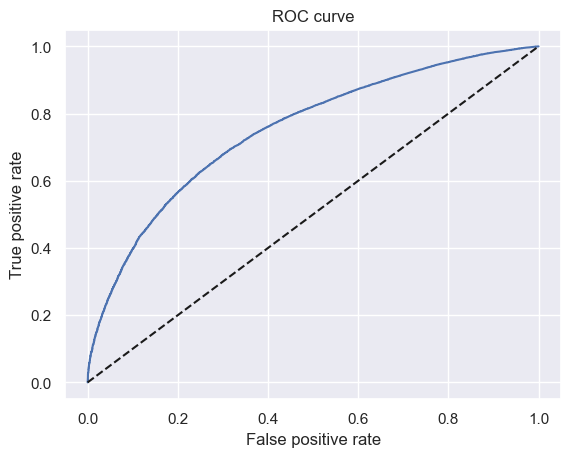

In [109]:
# Get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], 
                                 y_test_proba['y_hat_test_proba'])
# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [110]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) and GINI on test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
Gini = AUROC * 2 - 1

print('AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (Gini))

AUROC: 0.7512
Gini: 0.5024


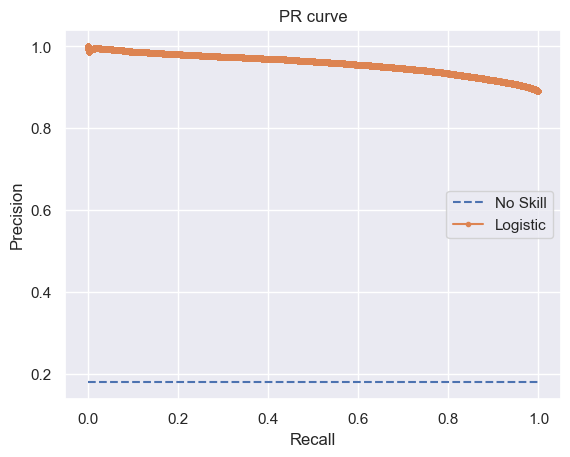

In [111]:
# Draw a PR curve
# Calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# Plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# Get the values required to plot a PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], 
                                                       y_test_proba['y_hat_test_proba'])
# Plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

## 10. Model Validation

Our credit risk model is intended to help the lender to manage their exposure to credit risk using credit scoring. 

Credit scoring is a process of assigning a score to a borrower which identify their risk  early on, so that appropriate action can be taken.

### 10.1. Scorecard Creation

The result of this machine learning model is mainly a credit score prediction with the same range of scores used by FICO. 

While the lender is already used a letter A-G grade system, FICO scores are commonly used as credit scores classification.

In [114]:
pd.DataFrame({'No.': [1,2,3,4,5],
              'FICO Score': ['300-579', '580-669', '670-739', '740-799', '> 800-850'],
              'Variable Predictiveness' : ['Poor','Fair','Good','Very Good','Excelent']}).style.hide_index()
min_score, max_score = 300, 850

In [115]:
df_scorecard = summary_table
df_scorecard['Features'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard['SubFeatures'] = df_scorecard['Feature name'].str.split(':').str[1]

# Calculate the sum of the minimum & maximum coefficients of each category
min_sum_coef = df_scorecard.groupby('Features')['Coefficients'].min().sum()
max_sum_coef = df_scorecard.groupby('Features')['Coefficients'].max().sum()

# Create a new columns with the adjusted score
df_scorecard['Scores'] = (df_scorecard['Coefficients'] * (max_score - min_score) / 
                                       (max_sum_coef - min_sum_coef)).round()
df_scorecard.loc[0, 'Scores'] = (((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / 
                                               (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score).round()
# Show the score card
pd.options.display.max_rows = None
df_scorecard[['Features','SubFeatures','Scores']]

,Features,SubFeatures,Scores
0,Intercept,NaN,556.0
1,initial_list_status,f,11.0
2,initial_list_status,w,15.0
3,verification_status,Verified,4.0
4,verification_status,Source Verified,3.0
5,verification_status,Not Verified,19.0
6,home_ownership,OTHER,-16.0
7,home_ownership,NONE,10.0
8,home_ownership,RENT,5.0
9,home_ownership,OWN,11.0


### 10.2. Scorecard Evaluation

In [122]:
# Calculate credit score for all observations
X_test_woe_transformed = woe_transform.transform(X_test)
X_test_woe_transformed.insert(0, 'Intercept', 1)

scorecard_scores = df_scorecard['Scores'].to_frame().to_numpy()
y_scores = X_test_woe_transformed.dot(scorecard_scores)
X_test['Scores'] = y_scores.values

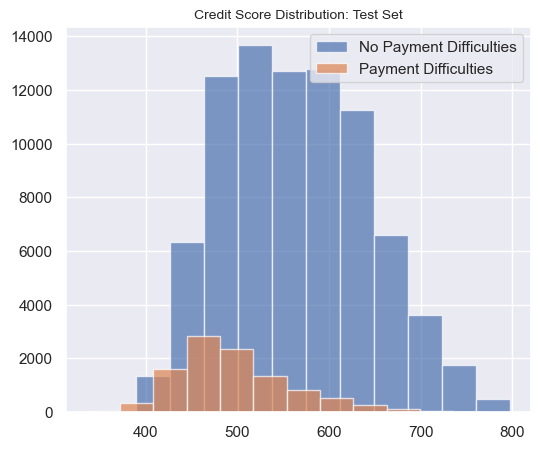

In [127]:
plt.figure(figsize=(6,5))
import random
import numpy
import math
from matplotlib import pyplot as plt

w = 40
n = math.ceil((X_test['Scores'].max() - X_test['Scores'].min())/w)
bins = numpy.linspace(-10, 10, 100)
plt.hist(X_test[y_test==1].Scores, alpha=0.7, label='No Payment Difficulties',bins = n)
plt.hist(X_test[y_test==0].Scores, alpha=0.7, label='Payment Difficulties',bins = n)
plt.legend(loc='upper right')
plt.title('Credit Score Distribution: Test Set',size=10)
plt.show()

With assumptions of the perfect theoritical model of FICO scorecard and inputs, a good model will clearly separate the blue/orange distribution; and have a smile shape, where:
1. Good customers (blue) with high credit scores to the very right
2. Bad customers (orange) with low credit scores to the very left.

Unfortunately, the current model doesn’t separate these distributions very well yet.